# Project to predict film prices using TMDB data

In [2]:
%matplotlib inline
import pandas as pd
import statistics
import math
from datetime import datetime
import numpy as np
import re
import ast
import seaborn as sb
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy.ma as ma
from IPython.display import display
from collections import Counter
import itertools
from itertools import chain
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics
import statsmodels.api as sm
pd.set_option('precision', 4)
import csv
import difflib
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from difflib import SequenceMatcher
import imdb
from imdb import IMDb
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
##read in the data and inspect size 
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
display(df_train.shape)
display(df_test.shape)


(3000, 23)

(4398, 22)

#### Distribution of NAs across columns

In [4]:
print(df_train.isna().sum(), df_test.isna().sum())


id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64 id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                 

In both the train and test set, the columns 'belongs_to_collection' and 'homepage' both have the most missing values.  Most likely, the homepage variable isn't helpful, so it will probably be dropped.  

### Formatting Date Columns

A cursory look at the data shows that the release_date column is of the form mm/dd/yy.  Without a century prefix in the year column it's not clear if a date is referring to 2018 or 1918.  Based on looking at the release_date data, it's easy to see that if a film has a yy value of 18 or less, it should be labeled 2018; all other films were released in the 20th century.  

The function below adds the century to clarify this.  In addition the column is converted to datetime format, and Year is extracted as a separate column.  One observation in the test set had a missing date, so I manually input it.  

In [5]:
#Filling in the one missing release date value in the test set 
df_test.loc[df_test['id']==3829,'release_date'] = '5/1/00'

In [6]:
def add_century(x):
    if int(x.split('/')[2]) <= 18:
        x = x.split('/')[0]+ '/' + x.split('/')[1]+ '/' + '20'+ x.split('/')[2]
    else:
        x = x.split('/')[0]+ '/' + x.split('/')[1] + '/' '19'+ x.split('/')[2]
    return(x)
    #return(datetime.strptime(x, '%m/%d/%Y'))

In [7]:
#Add century and convert columns to datetime
df_train['release_date'] = df_train['release_date'].apply(lambda x: x if pd.isnull(x) else add_century(x))
df_test['release_date'] = df_test['release_date'].apply(lambda x: x if pd.isnull(x) else add_century(x))

df_train['release_date'] = df_train['release_date'].apply(lambda x: x if pd.isnull(x) else pd.to_datetime(x, format='%m/%d/%Y'))
df_test['release_date'] = df_test['release_date'].apply(lambda x: x if pd.isnull(x) else pd.to_datetime(x, format='%m/%d/%Y'))

In [8]:
#add Year column
df_train['Year'] = df_train['release_date'].apply(lambda x: x.year)
df_test['Year'] = df_test['release_date'].apply(lambda x: x.year)

## Formatting and transforming currency variables

### Budget

In [9]:
print('Pct_train_zero: '+str(len(df_train[df_train['budget']==0])/len(df_train)),","
      'Pct_test_zero: '+str(len(df_test[df_test['budget']==0])/len(df_test)))

Pct_train_zero: 0.27066666666666667 ,Pct_test_zero: 0.27535243292405637


As seen above, both the training and test sets have about 27% of their budget data coded as 0.  Obviously, it doesn't make sense for a film to have a 0 budget.  After some inspection, it appears 0 is how missing data is coded for this variable.  

Logically, it seems like budget can be a strong predictor of revenue, so I want to keep this column in the analysis.  Some Kagglers have already done the job of filling in some budget revenue gaps, so my first step is to make use of their helpful additions.  However, there are a few datapoints other added and posted on their notebooks which are clearly wrong.  For example, Modern Times(id=850), had a budget of 1500000 not 90000000, which would have been exorbitant for its time.

In [10]:
df_train.loc[df_train['id'] == 16,'revenue'] = 192864          # Skinning
df_train.loc[df_train['id'] == 90,'budget'] = 30000000         # Sommersby          
df_train.loc[df_train['id'] == 118,'budget'] = 60000000        # Wild Hogs
df_train.loc[df_train['id'] == 149,'budget'] = 18000000        # Beethoven
df_train.loc[df_train['id'] == 313,'revenue'] = 12000000       # The Cookout 
df_train.loc[df_train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
df_train.loc[df_train['id'] == 464,'budget'] = 20000000        # Parenthood
df_train.loc[df_train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
df_train.loc[df_train['id'] == 513,'budget'] = 930000          # From Prada to Nada
df_train.loc[df_train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
df_train.loc[df_train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
df_train.loc[df_train['id'] == 850,'budget'] = 1500000       # Modern Times wrong!
df_train.loc[df_train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
df_train.loc[df_train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
df_train.loc[df_train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
df_train.loc[df_train['id'] == 1542,'budget'] = 1500000             # All at Once
df_train.loc[df_train['id'] == 1542,'budget'] = 15800000       # Crocodile Dundee II
df_train.loc[df_train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
df_train.loc[df_train['id'] == 1714,'budget'] = 46000000       # The Recruit
df_train.loc[df_train['id'] == 1721,'budget'] = 17500000       # Cocoon
df_train.loc[df_train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
df_train.loc[df_train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
df_train.loc[df_train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
df_train.loc[df_train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
df_train.loc[df_train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
df_train.loc[df_train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
df_train.loc[df_train['id'] == 2801,'budget'] = 10000000       # Fracture
df_test.loc[df_test['id'] == 3889,'budget'] = 15000000       # Colossal
df_test.loc[df_test['id'] == 6733,'budget'] = 5000000        # The Big Sick
df_test.loc[df_test['id'] == 3197,'budget'] = 8000000        # High-Rise
df_test.loc[df_test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
df_test.loc[df_test['id'] == 5704,'budget'] = 4300000        # French Connection II
df_test.loc[df_test['id'] == 6109,'budget'] = 281756         # Dogtooth
df_test.loc[df_test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
df_test.loc[df_test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
df_test.loc[df_test['id'] == 5591,'budget'] = 4000000        # The Orphanage
df_test.loc[df_test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee
#added by me
df_train.loc[df_train['id'] == 348,'budget'] = 12825000  #wind in the willows
df_train.loc[df_train['id'] == 640,'budget'] = 6000000  #Pollock
df_train.loc[df_train['id'] == 1918,'budget'] = 1600000  #Merry Widow
df_train.loc[df_train['id'] == 1801,'budget'] = 5000000  #cherry orchard
df_train.loc[df_train['id'] == 2033,'budget'] = 900000  #Farewell to Arms
df_train.loc[df_train['id'] == 2256,'budget'] = 30000000  #Lost & Found
df_train.loc[df_train['id'] == 1199,'budget'] = 5000000  #Every Which Way but Loose
df_train.loc[df_train['id'] == 1755,'budget'] = 2000000  #Mute Witness


Despite these additions, both the test and training still had over a quarter of their budget values missing.  To fill in these gaps, I looked to online data sources and also did some webscraping.  The first source I went to is The Numbers, a movie industry data website.  

After reading in a csv with The Numbers data, I use SequenceMatcher from the difflib package to see if titles in The Numbers data match any of the titles with budgets of less than 1000 in train or test, using a .9 cutoff for the text match.  I opted to use a budget cutoff of 1000 rather than look only at the missing data because I observed that in addition to the 0 values, a few films had incredibly low budgets, like a few hundred dollars or one dollar.

In [9]:
##read in numbers data and format column name
numbers = pd.read_csv('the_numbers.csv')
numbers.rename(columns={"Worldwide Gross": "Worldwide_Gross"},inplace=True)

#convert year column to date type
numbers['Year'] = pd.to_datetime(numbers['Year'].astype(str), format='%Y')
numbers['Year'] = numbers['Year'].apply(lambda x: x.year)

In [10]:
#create dataframe where budget is less than 1000 for train and test sets
missing_budg_train = df_train.loc[df_train['budget']<=1000,:]
missing_budg_test = df_test.loc[df_test['budget']<=1000,:]

#Get list of titles for films in above dataframes and films in The Numbers data
missing_budg_train_list = missing_budg_train['original_title'].tolist()
missing_budg_test_list = missing_budg_test['original_title'].tolist()
numbers_list = numbers['Movie'].tolist()

In [46]:
## Using SequenceMatcher, get films that exist in both the error lists and The list
similar_train = [(a,b) for (a, b) in itertools.product(missing_budg_train_list, numbers_list) if SequenceMatcher(None, a,b).ratio()>.9]
similar_test = [(a,b) for (a, b) in itertools.product(missing_budg_test_list, numbers_list) if SequenceMatcher(None, a,b).ratio()>.9]

In [72]:
similar_train_df = pd.DataFrame(similar_train, columns=['original_title', 'num_title'])
similar_test_df = pd.DataFrame(similar_test, columns=['original_title', 'num_title'])

              original_title                  num_title
0                     Wilson                     Wilson
1            Won't Back Down            Won't Back Down
2                     Frozen                     Frozen
3  Girl with a Pearl Earring  Girl with a Pearl Earring
4      Home for the Holidays      Home for the Holidays                 original_title                   num_title
0  I Married a Strange Person!  I Married a Strange Person
1                Obvious Child               Obvious Child
2            American Splendor           American Splendor
3                       Genius                      Genius
4                    Submarine                   Submarine


In [37]:
#Create new dfs that merge numbers_df with dfs created using SequenceMatcher
numbers_found_train = pd.merge(numbers,similar_train_df, how='inner',
        left_on='Movie', right_on='num_title')
numbers_found_test= pd.merge(numbers,similar_test_df, how='inner',
        left_on='Movie', right_on='num_title')

                          Movie Month  Day  Year  Budget  Domestic_Gross  \
0                        Frozen   Nov   22  2013 150.000         400.738   
1  Murder on the Orient Express   Nov   10  2017  55.000         102.827   
2  Murder on the Orient Express   Nov   10  2017  55.000         102.827   
3  Murder on the Orient Express   Nov   10  2017  55.000         102.827   
4  Murder on the Orient Express   Nov   10  2017  55.000         102.827   

   Worldwide_Gross                original_title                     num_title  
0         1274.235                        Frozen                        Frozen  
1          349.214  Murder on the Orient Express  Murder on the Orient Express  
2          349.214  Murder on the Orient Express  Murder on the Orient Express  
3          349.214  Murder on the Orient Express  Murder on the Orient Express  
4          349.214  Murder on the Orient Express  Murder on the Orient Express  
                                Movie Month  Day  Year  B

In [39]:
#drop duplicates and adjust budget numbers
numbers_found_train.drop_duplicates(inplace=True)
numbers_found_train['Budget'] = numbers_found_test['Budget'].apply(lambda x: x*1000000)

numbers_found_test.drop_duplicates(inplace=True)
numbers_found_test['Budget'] = numbers_found_test['Budget'].apply(lambda x: x*1000000)

In [40]:
numbers_found_test.drop(columns=['Movie'], inplace=True)
numbers_found_train.drop(columns=['Movie'],inplace=True)

In [42]:
numbers_found_test['Match_Score'] = numbers_found_test.apply(lambda x: SequenceMatcher(None, x['original_title'], 
                                                                                       x['num_title']).ratio(),axis=1)
numbers_found_train['Match_Score'] = numbers_found_train.apply(lambda x: SequenceMatcher(None, x['original_title'], 
                                                                                           x['num_title']).ratio(),axis=1)
   

With a .9 cutoff, most film titles matched, but some were slightly different, so that had to be investigated. Those films that were certainly not matches were dropped.  Below, we can see that sometimes the film title was simply written differently or there were extraneous characters(e.g., 'Crocodile Dundee 2' and 'Crocodile Dundee','Romance and Cigarettes' and 'Romance \& Cigarettes').  However, other are clearly different movies(e.g., 'Gnomeo and Juliet' and 'Romeo and Juliet').  For others who'd like to run this same analysis, it may be best to use a threshhold higher than .9 to prevent mismatches.  

In [8]:
numbers_found_train[numbers_found_train['Match_Score']!=1].head()

,Month,Day,Year,Budget,Domestic_Gross,Worldwide_Gross,original_title,num_title,Match_Score
4,May,25,1988,18500000.000,109.306,239.606,Crocodile Dundee II,Crocodile Dundee 2,0.919
26,Jun,28,1985,20000000.000,37.800,37.800,St. Elmo's Fire,St. ElmoÕs Fire,0.933
54,Jan,6,2006,5400000.000,6.090,6.590,Grandma's Boy,GrandmaÕs Boy,0.923
58,Jul,22,2016,55000000.000,4.418,4.418,Don't Think Twice,DonÕt Think Twice,0.941
62,Sep,7,2007,17000000.000,0.551,3.231,Romance & Cigarettes,Romance and Cigarettes,0.905


In [45]:
#Remove films that were not true matches
numbers_found_train.drop(index=[5,11,18,47,60,80], inplace=True)
#drop films that are different
numbers_found_test.drop(index=[4,6,7,9,53, 92, 95], inplace=True)

Now I can join the Numbers dataframes to the original dataframes.  I join on original_title, however, I then check if the years are the same, because I don't want to join the same named movie from different eras( for example a Hamlet from the 1960s to a version from the 2000s).  Movies with the same name but a year difference of 2 or greater are ignored--their budget data doesn't replace the value from the original dataset.     

In [47]:
df_train= pd.merge(df_train, numbers_found_train, how='left',
        left_on=['original_title'], right_on=['original_title'])

In [48]:
df_test= pd.merge(df_test, numbers_found_test, how='left',
        left_on=['original_title'], right_on=['original_title'])

In [49]:
df_train['budget'] = df_train.apply(lambda row: row['Budget'] if (pd.isnull(row['Budget'])==False
                                                                  and abs(row['Year_x']-row['Year_y'])<2) else row['budget'], axis=1)
df_test['budget'] = df_test.apply(lambda row: row['Budget'] if (pd.isnull(row['Budget'])==False
                                                                  and abs(row['Year_x']-row['Year_y'])<2) else row['budget'], axis=1)
df_test.drop(columns=['Budget'],inplace=True)
df_train.drop(columns=['Budget'],inplace=True)

In [51]:
##change column names and drop extra col
df_test.rename(columns={"Year_x": "Year"},inplace=True)
df_train.rename(columns={"Year_x": "Year"},inplace=True)
df_test.drop(columns="Year_y", inplace=True)
df_train.drop(columns="Year_y", inplace=True)

In [50]:
##save initial_dataframe unedited
print("Current Missing Count:",len(df_test[df_test['budget']==0])/len(df_test))
print("Current Missing Count:",len(df_train[df_train['budget']==0])/len(df_train))

Current Missing Count: 0.2556818181818182
Current Missing Count: 0.24608724608724608


So,the percentage of missing budgets was reduced slightly.  

### Looking for missing budget data using IMDB API

The Numbers helped fill in some missing information, but there is still a lot present.  So, I try using the imdbpy package to fill in some missing data.   

In [119]:
#instantaiate imdb class
from imdb import IMDb
ia = imdb.IMDb()

In [243]:
#Again, compile list of titles with missing budget numbers
miss_list_test = df_test[df_test['budget']<1000]['original_title'].tolist()
miss_list_train = df_train[df_train['budget']<1000]['original_title'].tolist()

The steps I used in working with the API are the following:
 - Retrieve the ID for the best match using getID
 - Create dataframe of those films with their box office information
 - Clean the data to remove commas and dollar signs
 - Merge this budget data with the train and test dataframes.  

In [254]:
#get IMDB ids corresponding to films in updated missing_lists
test_movie_id = [(movie,ia.search_movie(movie)[0].getID(), ia.search_movie(movie)[0]['title']) for movie in miss_list_test if len(ia.search_movie(movie))>1]
train_movie_id = [(movie,ia.search_movie(movie)[0].getID(),ia.search_movie(movie)[0]['title']) for movie in miss_list_train if len(ia.search_movie(movie))>1]

In [260]:
#create dfs of those films found using getID
test_movie_id_df = pd.DataFrame(test_movie_id, columns =['Test_Name','IMDB_ID', 'IMDB_Name']) 
train_movie_id_df = pd.DataFrame(train_movie_id, columns =['Train_Name','IMDB_ID', 'IMDB_Name']) 

In [294]:
#with those ids, create dataframe that pulls title, budget and year for those films
#for train df
title_list=[]
budget_list=[]
year_list=[]
id_list = []
movie_list = []
for tup in train_movie_id:
    movie = tup[0]
    ids=tup[1]
    title = tup[2]
    match = ia.get_movie(ids)
    if ('box office' in match.infoset2keys['main']):
        budget = (match['box office'].get('Budget'))
        year = match['year']
        if (budget!=None):
            title_list.append(title)
            id_list.append(ids)
            movie_list.append(movie)
            budget_list.append(budget)
            year_list.append(year)    
#imdbpy_train_df = pd.DataFrame({'movie': movie_list, 'id': id_list,'title': title_list,'budget': budget_list,'year': year_list})

In [295]:
#with those ids, create dataframe that pulls title, budget and year for those films
#for test dataframe
title_list_2=[]
budget_list_2=[]
year_list_2=[]
id_list_2 = []
movie_list_2 = []
for tup in test_movie_id:
    movie = tup[0]
    ids=tup[1]
    title = tup[2]
    match = ia.get_movie(ids)
    if ('box office' in match.infoset2keys['main']):
        budget = (match['box office'].get('Budget'))
        year = match['year']
        if (budget!=None):
            id_list_2.append(ids)
            movie_list_2.append(movie)
            title_list_2.append(title)
            budget_list_2.append(budget)
            year_list_2.append(year)    
#imdbpy_test_df = pd.DataFrame({'movie': movie_list, 'id': id_list,'title': title_list,'budget': budget_list,'year': year_list })

In [598]:
imdbpy_train_df = pd.DataFrame({'movie': movie_list, 'id': id_list,'title': title_list,'budget': budget_list,'year': year_list})
imdbpy_test_df = pd.DataFrame({'movie': movie_list_2, 'id': id_list_2,'title': title_list_2,'budget': budget_list_2,'year': year_list_2})

In [599]:
imdbpy_train_df['currency'] = imdbpy_train_df.apply(lambda x: x['budget'][0:3] if x['budget'][0]!='$' else None,axis=1)
imdbpy_test_df['currency'] = imdbpy_test_df.apply(lambda x: x['budget'][0:3] if x['budget'][0]!='$' else None,axis=1)
##clean up data and convert to int
imdbpy_train_df['budget'] = imdbpy_train_df['budget'].str.replace(',', '')
imdbpy_train_df['budget'] = imdbpy_train_df['budget'].str.replace('$', '')
imdbpy_test_df['budget'] = imdbpy_test_df['budget'].str.replace(',', '')
imdbpy_test_df['budget'] = imdbpy_test_df['budget'].str.replace('$', '')

imdbpy_train_df['budget'] = imdbpy_train_df['budget'].apply(lambda x: x.split()[0])
imdbpy_test_df['budget'] = imdbpy_test_df['budget'].apply(lambda x: x.split()[0])

The estimated budgets on IMDB are not all in USD, and I wanted to retain the information I pulled from the API, I used publicly available data on average yearly exchange rates to convert foreign values to USD. For some more common currencies, like the Euro and British Pound, I created dataframes of historical prices to then join to my existing dataframes.  Other data was pulled in a less structured fashion.   

In [600]:
non_US_train = imdbpy_train_df[imdbpy_train_df['currency'].isnull()==False]
non_US_test = imdbpy_test_df[imdbpy_test_df['currency'].isnull()==False]
non_US_train.loc[:,'budget'] = non_US_train.apply(lambda x: x['budget'].replace(x['currency'], ''), axis=1)
non_US_test.loc[:,'budget'] = non_US_test.apply(lambda x: x['budget'].replace(x['currency'], ''), axis=1)

/Users/samuelcolon/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [601]:
##Use historical average of EUR to USD to convert EUR currency budgets.  
EUR_USD_Conv = pd.read_excel('FXTOP_PRICES_EUR_USD.xlsx', header=[1], usecols="A:B")
EUR_USD_Conv_2 = pd.read_excel('FXTOP_PRICES_EUR_USD_2.xlsx', header=[1],usecols="A:B")
EUR_USD_Conv_3 = pd.read_excel('FXTOP_PRICES_EUR_USD_3.xlsx', header=[1],usecols="A:B")
EUR_USD_Conv_4 = pd.read_excel('FXTOP_PRICES_EUR_USD_4.xlsx', header=[1],usecols="A:B")
EUR_USD_Conv_5 = pd.read_excel('FXTOP_PRICES_EUR_USD_5.xlsx', header=[1],usecols="A:B")
##concatenate conversion list and drop dups
EUR_USD_Conv_Complete = pd.concat([EUR_USD_Conv, EUR_USD_Conv_2, EUR_USD_Conv_3, EUR_USD_Conv_4, EUR_USD_Conv_5],ignore_index=True)
EUR_USD_Conv_Complete.drop_duplicates(inplace=True)
EUR_USD_Conv_Complete['currency']='EUR'
##merge those values into the non_US_train_df
non_US_train = pd.merge(non_US_train, EUR_USD_Conv_Complete, left_on=['year','currency'], right_on=['YEAR','currency'], how='left')
non_US_test = pd.merge(non_US_test, EUR_USD_Conv_Complete, left_on=['year','currency'], right_on=['YEAR','currency'],how='left')
non_US_train.drop(columns=['YEAR'],inplace=True)
non_US_test.drop(columns=['YEAR'],inplace=True)

In [602]:
GBP_USD_Conv = pd.read_excel('FXTOP_PRICES_GBP_USD.xlsx', header=[1], usecols="A:B")
GBP_USD_Conv_2 = pd.read_excel('FXTOP_PRICES_GBP_USD_2.xlsx', header=[1], usecols="A:B")
GBP_USD_Conv_Complete = pd.concat([GBP_USD_Conv, GBP_USD_Conv_2],ignore_index=True)
GBP_USD_Conv_Complete['currency']='GBP'
##merge those values into the non_US_train_df
non_US_train = pd.merge(non_US_train, GBP_USD_Conv_Complete, left_on=['year','currency'], right_on=['YEAR','currency'], how='left')
non_US_test = pd.merge(non_US_test, GBP_USD_Conv_Complete, left_on=['year','currency'], right_on=['YEAR','currency'],how='left')
non_US_train.drop(columns=['YEAR'],inplace=True)
non_US_test.drop(columns=['YEAR'],inplace=True)
###fill  verage
non_US_train['AVERAGE_x'] = non_US_train.apply(lambda x: x['AVERAGE_y'] if x['currency']=='GBP' else x['AVERAGE_x'],axis=1)
non_US_test['AVERAGE_x'] = non_US_test.apply(lambda x: x['AVERAGE_y'] if x['currency']=='GBP' else x['AVERAGE_x'],axis=1)
non_US_train.drop(columns=['AVERAGE_y'],inplace=True)
non_US_test.drop(columns=['AVERAGE_y'],inplace=True)


In [603]:
###fill in test gaps
non_US_test.loc[non_US_test['id']=='0110076', 'AVERAGE_x'] = .031
non_US_test.loc[non_US_test['id']=='0375611', 'AVERAGE_x'] = .022
non_US_test.loc[non_US_test['id']=='1379228', 'AVERAGE_x'] = .0206
non_US_test.loc[non_US_test['id']=='1114277', 'AVERAGE_x'] = .935
non_US_test.loc[non_US_test['id']=='1815717', 'AVERAGE_x'] = .971
non_US_test.loc[non_US_test['id']=='1695765', 'AVERAGE_x'] = .08
non_US_test.loc[non_US_test['id']=='9362276', 'AVERAGE_x'] = .0003
non_US_test.loc[non_US_test['id']=='0113568', 'AVERAGE_x'] = .0106
non_US_test.loc[non_US_test['id']=='0250223', 'AVERAGE_x'] = .144
non_US_test.loc[non_US_test['id']=='0221073', 'AVERAGE_x'] = .581
non_US_test.loc[non_US_test['id']=='0080516', 'AVERAGE_x'] = .856
non_US_test.loc[non_US_test['id']=='0102848', 'AVERAGE_x'] = .872
non_US_test.loc[non_US_test['id']=='0079891', 'AVERAGE_x'] = .527
non_US_test.loc[non_US_test['id']=='0102848', 'AVERAGE_x'] = .872
non_US_test.loc[non_US_test['id']=='0402249', 'AVERAGE_x'] = .825

##fill in train gaps
non_US_train.loc[non_US_train['id']=='3704050', 'AVERAGE_x'] = .783
non_US_train.loc[non_US_train['id']=='0084469', 'AVERAGE_x'] = .811
non_US_train.loc[non_US_train['id']=='0099606', 'AVERAGE_x'] = .85
non_US_train.loc[non_US_train['id']=='0133385', 'AVERAGE_x'] = .16
non_US_train.loc[non_US_train['id']=='0183869', 'AVERAGE_x'] = .14
non_US_train.loc[non_US_train['id']=='0374271', 'AVERAGE_x'] = .021
non_US_train.loc[non_US_train['id']=='0488870', 'AVERAGE_x'] = .009
non_US_train.loc[non_US_train['id']=='2832470', 'AVERAGE_x'] = .16
non_US_train.loc[non_US_train['id']=='1821641', 'AVERAGE_x'] = .316
non_US_train.loc[non_US_train['id']=='0339230', 'AVERAGE_x'] = .124
non_US_train.loc[non_US_train['id']=='0095302', 'AVERAGE_x'] = 1.78

In [604]:
#transfrom train budget numbers
non_US_train['budget'] = non_US_train['budget'].astype('float')
non_US_train['AVERAGE_x'] = non_US_train['AVERAGE_x'].astype('float')
non_US_train['budget'] = non_US_train['AVERAGE_x']*non_US_train['budget']

#transfrom test budget numbers
non_US_test['budget'] = non_US_test['budget'].astype('float')
non_US_test['AVERAGE_x'] = non_US_test['AVERAGE_x'].astype('float')
non_US_test['budget'] = non_US_test['AVERAGE_x']*non_US_test['budget']


I merge the data I pulled from the imdbpy package from with the additional currency information.  In addition, as before with The Numbers Data, I look at the match score and investigate to see if films were erroneously matched

In [605]:
imdbpy_train_df = pd.merge(imdbpy_train_df, non_US_train[['budget', 'title']], 
                          left_on = 'title', right_on='title', how='left')
imdbpy_train_df['budget_x'] = imdbpy_train_df.apply(lambda x: x['budget_y'] if np.isnan(x['budget_y'])==False else x['budget_x'],axis=1)
imdbpy_train_df['budget_x'] = imdbpy_train_df['budget_x'].astype('float')
imdbpy_train_df.rename(columns={"budget_x": "budget"},inplace=True)
imdbpy_train_df.drop(columns=['currency', 'budget_y'], inplace=True)
imdbpy_train_df.head()

imdbpy_test_df = pd.merge(imdbpy_test_df , non_US_test[['budget', 'title']], 
                          left_on = 'title', right_on='title', how='left')
imdbpy_test_df ['budget_x'] = imdbpy_test_df .apply(lambda x: x['budget_y'] if np.isnan(x['budget_y'])==False else x['budget_x'],axis=1)
imdbpy_test_df ['budget_x'] = imdbpy_test_df ['budget_x'].astype('float')
imdbpy_test_df .rename(columns={"budget_x": "budget"},inplace=True)
imdbpy_test_df .drop(columns=['currency', 'budget_y'], inplace=True)

In [608]:
imdbpy_train_df['Match_Score'] = imdbpy_train_df.apply(lambda x: SequenceMatcher(None, x['movie'], 
                                                                                       x['title']).ratio(),axis=1)
imdbpy_test_df['Match_Score'] = imdbpy_test_df.apply(lambda x: SequenceMatcher(None, x['movie'], 
                                                                                           x['title']).ratio(),axis=1)
   

In [10]:
imdbpy_train_df[imdbpy_train_df['Match_Score']<1].head()

,budget,id,movie,title,year,Match_Score
1,6973796.875,1082009,Joueuse,Queen to Play,2009,0.300
6,250000.000,62480,Le Week-End,Weekend,1967,0.667
7,110000000.000,1219827,GHOST IN THE SHELL,Ghost in the Shell,2017,0.278
12,43939200.000,133385,Astérix & Obélix contre César,Asterix and Obelix vs. Caesar,1999,0.655
16,340000.000,76150,Communion,"Alice, Sweet Alice",1976,0.074


Again, I see some films are mismatches because of differences in formatting, and some because of title language differences ('Joueuse' was the original title of 'Queen to Play'.  After looking at this data, I found I had to drop some films because of the matches being incorrect.  In addition, I again check the difference in years between the new data I've pulled and my existing data.    

In [611]:
##Drop mismatches in train and test
imdbpy_train_df.drop(index=[48,64,76,81,85,88,119,122,137,156,160],inplace=True)
##need to drop some manually
imdbpy_test_df.drop(index=[122,139,172,174,176,179,180,187,211,243,244,252,257,
                          11,20,21,26,43,68,82,89,105,118,123,128,227,225,236,202],inplace=True)

In [12]:
##Final dataset
imdbpy_train_df.head()

,budget,id,movie,title,year,Match_Score
0,6000000.000,81031,The Last Flight of Noah's Ark,The Last Flight of Noah's Ark,1980,1.000
1,6973796.875,1082009,Joueuse,Queen to Play,2009,0.300
2,150000000.000,2294629,Frozen,Frozen,2013,1.000
3,3000000.000,81760,Windwalker,Windwalker,1980,1.000
4,7600000.000,89822,Police Academy 2: Their First Assignment,Police Academy 2: Their First Assignment,1985,1.000


In [69]:
##merge dfs with data from IMDB API
df_train = pd.merge(df_train, imdbpy_train_df[['budget', 'movie', 'year']], left_on='original_title',
                            right_on='movie',how="left")

##merge dfs with data from IMDB API
df_test = pd.merge(df_test, imdbpy_test_df[['budget', 'movie', 'year']], left_on='original_title',
                            right_on='movie',how="left")

In [73]:
df_train['budget_x'] = df_train.apply(lambda row: row['budget_y'] if (pd.isnull(row['budget_y'])==False
                                                                  and abs(row['Year']-row['year'])<2) else row['budget_x'], axis=1)
df_test['budget_x'] = df_test.apply(lambda row: row['budget_y'] if (pd.isnull(row['budget_y'])==False
                                                                  and abs(row['Year']-row['year'])<2) else row['budget_x'], axis=1)

In [75]:
df_test.drop(columns=['budget_y'],inplace=True)
df_train.drop(columns=['budget_y'],inplace=True)
df_test.rename(columns={"budget_x": "budget"},inplace=True)
df_train.rename(columns={"budget_x": "budget"},inplace=True)

In [78]:
print("Test missing count before:",len(df_test[df_test['budget']==0])/len(df_test))
print("Train missing count before:",len(df_train[df_train['budget']==0])/len(df_train))

Test missing count before: 0.21113636363636365
Train missing count before: 0.20890069744271006


So, using the Numbers and imdbpy, I've now been able to reduce the missing budget data to close to 21% for both test and train.  

# Further attempts to collect missing data.  

### Using beautifulsoup and requests, I try to pull data from The Numbers website, in case the dataset I had was incomplete. 

In [87]:
#Lists of likely erroneous or missing budgets
err_train_list = df_train[(df_train['budget']==0) | (df_train['budget']<1000)]['original_title'].tolist()
err_test_list= df_test[(df_test['budget']==0) | (df_test['budget']<1000)]['original_title'].tolist()

In [256]:
##Edit the film titles so their formatted like The Numbers website urls
err_train_list= [el.replace(":", "-") for el in err_train_list]
err_train_list= [el.replace(" ", "-") for el in err_train_list]
err_train_list= [el.replace("--", "-") for el in err_train_list]
print(err_train_list[0:4])

['마린보이', 'Control-Room', 'Muppet-Treasure-Island', 'Revenge-of-the-Nerds-II-Nerds-in-Paradise']


In [257]:
err_test_list= [el.replace(":", "-") for el in err_test_list]
err_test_list= [el.replace(" ", "-") for el in err_test_list]
err_test_list= [el.replace("--", "-") for el in err_test_list]

In [264]:
##get list of urls based on standard format found on the-numbers.com
url_train_list=[]
for elem in err_train_list:
    url = "https://www.the-numbers.com/movie/{}#tab=summary".format(elem)
    url_train_list.append(url)  

In [266]:
url_test_list=[]
for elem in err_test_list:
    url = "https://www.the-numbers.com/movie/{}#tab=summary".format(elem)
    url_test_list.append(url)

In [280]:
import requests
url = 'https://www.the-numbers.com/movie/Revenge-of-the-Nerds-II-Nerds-in-Paradise#tab=summary'
headers = {'User-Agent': 'Mozilla/5.0'}
r = requests.get(url, headers=headers)
soup = BeautifulSoup(r.text, 'html.parser')
title_string = soup.body.h1.find_all_next(string=True)[0]
year = title_string[title_string.find("(")+1:title_string.find(")")]
#print(soup.find("div", {"id": "main"}).select('h1'))

In [297]:
soup_list=[]

headers = {'User-Agent': 'Mozilla/5.0'}
pattern = re.compile(r'Budget')
for url in url_test_list:
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, 'html.parser')
    try:
        budget= soup.find('b', text=pattern).find_next('td').getText()
        if budget:
            title_string = soup.body.h1.find_all_next(string=True)[0]
            year = title_string[title_string.find("(")+1:title_string.find(")")]
            soup_list.append([budget, title_string, year])
    except AttributeError as ex:
        pass
        #title_string = soup.body.h1.find_all_next(string=True)[0]
        #print(soup.find('b', text=pattern).find_next('td').getText())


In [299]:
soup_list_2=[]

headers = {'User-Agent': 'Mozilla/5.0'}
pattern = re.compile(r'Budget')
for url in url_train_list:
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, 'html.parser')
    try:
        budget= soup.find('b', text=pattern).find_next('td').getText()
        if budget:
            title_string = soup.body.h1.find_all_next(string=True)[0]
            year = title_string[title_string.find("(")+1:title_string.find(")")]
            soup_list_2.append([budget, title_string, year])
    except AttributeError as ex:
        pass
        #title_string = soup.body.h1.find_all_next(string=True)[0]
        #print(soup.find('b', text=pattern).find_next('td').getText())

In [344]:
##df for soup_list and soup_list2
test_soup_df = pd.DataFrame.from_records(soup_list, columns =['Budget', 'Title', 'Year'])
train_soup_df = pd.DataFrame.from_records(soup_list_2, columns =['Budget', 'Title', 'Year'])

In [345]:
test_soup_df['Budget'] = test_soup_df['Budget'].str.replace(',', '')
test_soup_df['Budget'] = test_soup_df['Budget'].str.replace('$', '')
train_soup_df['Budget'] = train_soup_df['Budget'].str.replace(',', '')
train_soup_df['Budget'] = train_soup_df['Budget'].str.replace('$', '')

test_soup_df['Title'] = test_soup_df['Title'].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x).strip())
train_soup_df['Title'] = train_soup_df['Title'].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x).strip())

test_soup_df['Year'] = test_soup_df['Year'].astype('int')
train_soup_df['Year'] = train_soup_df['Year'].astype('int')

In [346]:
#join to df_train
test_soup_df = pd.merge(df_test[['original_title','Year']], test_soup_df, how='left',
        left_on=['original_title'], right_on=['Title'])

#join to df_train
train_soup_df = pd.merge(df_train[['original_title','Year']], train_soup_df, how='left',
        left_on=['original_title'], right_on=['Title'])

train_soup_df = train_soup_df[train_soup_df['Title'].isnull()==False]
test_soup_df = test_soup_df[test_soup_df['Title'].isnull()==False]

In [350]:
train_soup_df.drop(columns=['Year_y', 'Title', 'Year_x'])
test_soup_df.drop(columns=['Year_y', 'Title','Year_x'])

,original_title,Budget
486,Deck the Halls,51000000
3900,Krisha,30000
4121,Fighting,25000000


In [351]:
##now you can join these to the existing dataframes
df_train = pd.merge(df_train, train_soup_df, how='left',
        left_on='original_title', right_on='original_title')
df_test = pd.merge(df_test, test_soup_df, how='left',
        left_on='original_title', right_on='original_title')

In [354]:
#update budget nums
df_test['budget']= df_test.apply(lambda row: row['Budget'] if pd.isnull(row['Budget'])==False else row['budget'],
                                           axis=1)
df_train['budget']= df_train.apply(lambda row: row['Budget'] if pd.isnull(row['Budget'])==False else row['budget'],
                                           axis=1)

### This method only resulted in pulling in a few extra datapoints for the train and test sets. 

# Analysis of Revenue

Revenue is what is to be predicted, so errors in this field are quite important.   

In [470]:
df_train['revenue'].describe()

count         3011.000
mean      66724159.968
std      137417400.940
min              1.000
25%        2403939.500
50%       16810383.000
75%       68822623.000
max     1519557910.000
Name: revenue, dtype: float64

I can see right away that it doesn't make sense to have a revenue of 1, so I looked into the accuracy of this column.  Again, I was able to manually update some incorrect information, and I dropped rows where I couldn't find reliable informaiton.    

In [471]:
df_train[df_train['revenue']==1][['original_title', 'Year', 'id']]
df_train.loc[df_train['id'] == 348,'revenue'] = 2032680 ##wind in the willows
df_train.loc[df_train['id'] == 1755,'revenue'] = 1981961 ##Vermist
df_train.loc[df_train['id'] == 1875,'revenue'] = 1125910 ##Mute Witness
df_train.loc[df_train['id'] == 1918,'revenue'] = 1900000 ##Merry Widow
df_train.loc[df_train['id'] == 696,'revenue'] = 3423084  ##Tere Naam
df_train.loc[df_train['id'] == 640,'revenue'] = 8000000  ##Pollock
df_train.loc[df_train['id'] == 1191,'revenue'] = 7660857  ##He-man
df_train.loc[df_train['id'] == 1347,'revenue'] = 24079  ##East of Eden
df_train.loc[df_train['id'] == 1542,'revenue'] = 3514780  ##All at once(Russian Film) ## maybe drop
df_train.loc[df_train['id'] == 2118,'revenue'] = 344992  ##Amercian adobo
df_train.loc[df_train['id'] == 2252,'revenue'] = 4690492  ##Bodyguard  ## change budget too
df_train.loc[df_train['id'] == 2583,'revenue'] = 3930933  ##Kopps 
df_train.loc[df_train['id'] == 97,'revenue'] = 430000  #nuit blanche, budget = 4600000
df_train.loc[df_train['id'] == 151,'revenue'] = 18000000 #windwalker
df_train.loc[df_train['id'] == 153,'revenue'] = 241278 #paperhouse
df_train.loc[df_train['id'] == 281,'revenue'] = 10155691 #Bats
df_train.loc[df_train['id'] == 499,'revenue'] = 25317 #Lake of fire
df_train.loc[df_train['id'] == 665,'revenue'] = 70936 #My Summer Story
df_train.loc[df_train['id'] == 1199,'revenue'] = 85196485 #Evert which way but loose
df_train.loc[df_train['id'] == 1241,'revenue'] = 835095#Khiladi
df_train.loc[df_train['id'] == 1282,'revenue'] = 46789413#Death at a Funeral
df_train.loc[df_train['id'] == 1377,'revenue'] = 5401447#Lady Macbeth
df_train.loc[df_train['id'] == 1801,'revenue'] = 135280###The Cherry Orchard
df_train.loc[df_train['id'] == 1885,'revenue'] = 23726793###In the Cut
df_train.loc[df_train['id'] == 1965,'revenue'] = 53048###HereMakono
df_train.loc[df_train['id'] == 2091,'revenue'] = 18369###DeadFall
df_train.loc[df_train['id'] == 2256,'revenue'] = 6552255###Lost & Found
df_train.loc[df_train['id'] == 348,'revenue'] = 1000000 ## wind in the willows
df_train.loc[df_train['id'] == 97,'revenue'] = 430000 ## nuit blanche
df_train.loc[df_train['id'] == 665,'revenue'] = 70000 ## summer story
df_train.loc[df_train['id'] == 1199,'revenue'] = 104300000## ever which way
df_train.loc[df_train['id'] == 1263,'revenue'] = 2970000## phil exper 2
df_train.loc[df_train['id'] == 1755,'revenue'] = 1125910## mute witness
df_train.loc[df_train['id'] == 1801,'revenue'] = 135280## Cherry orchard
df_train.loc[df_train['id'] == 1918,'revenue'] = 1900000## mery widow
df_train.loc[df_train['id'] == 2256,'revenue'] = 6552255## lost adn found
df_train.loc[df_train['id'] == 2811,'revenue'] = 473965## ev will be fine
df_train.loc[df_train['id'] == 1542,'revenue'] = 3514780## Все и сразу
df_train.loc[df_train['id'] == 1426,'revenue'] = 391000000## superman returns
df_train.loc[df_train['id'] == 1426,'budget'] = 204000000## superman returns
df_train.loc[df_train['id'] == 850,'budget'] = 1500000       # Modern Times wrong!
df_test.loc[df_test['id'] == 3120,'budget'] = 1200000       # Metropolis wrong!
df_test.loc[df_test['id'] == 6494,'budget'] = 2200000       # Manchurian Candidate wrong!

In [472]:
##drop bc of lack of information reliable
df_train.drop(index=[334, 2392,269,146,34,153,225,314,2033,2041], inplace=True)

In [474]:
df_train['revenue'].describe()

count         3001.000
mean      66791731.144
std      137450130.070
min             10.000
25%        2585639.000
50%       16929123.000
75%       68929150.000
max     1519557910.000
Name: revenue, dtype: float64

## Adjustments for Inflation

The dataset has movies from the 1920s to 2018 and the financial data is recorded in nominal terms.  Therefore to analyze revenue and budget over time, they should be first adjusted for inflation.  I used the yearly average of the CPI, which can be found at stlouisfed.org to perform the adjustmenst.  

In [33]:
#read in consumer price index history
CPI = pd.read_csv('CPI.csv', dtype={'Year': str, 'Annual_Avg': np.float64 , 'Annual_Percent_Change': np.float64})

In [34]:
CPI.head()

,Year,Annual_Avg,Annual_Percent_Change
0,1913,9.900,0.000
1,1914,10.000,1.300
2,1915,10.100,0.900
3,1916,10.900,7.700
4,1917,12.800,17.800


In [35]:
#Convert CPI Year column to date
CPI['Year'] = CPI['Year'].astype('datetime64[ns]')

In [36]:
CPI['Year'] = CPI['Year'].apply(lambda x: x.year)

In [37]:
##join CPI table to dataframes
df_train = pd.merge(df_train, CPI, how="left", left_on='Year', right_on='Year')
df_test = pd.merge(df_test, CPI, how="left", left_on='Year', right_on='Year')

In [38]:
##adjust revenue for inflation
df_train['Adj_rev'] = df_train['revenue']/df_train['Annual_Avg']

In [39]:
df_train['Adj_budg'] = df_train['budget']/df_train['Annual_Avg']
df_test['Adj_budg'] = df_test['budget']/df_test['Annual_Avg']

### Revenue vs. budget

With the adjustments for inflation complete and data enrichment taken as far as I was able to take it in a small timeframe, I first began analsis of the relationship between revenue and budget.  In looking at this relationship, I  removed the 0 budget films to make sure the analysis is sensible.  

In [30]:
df_train = pd.read_csv('df_train.csv')
df_test  = pd.read_csv('df_test.csv')

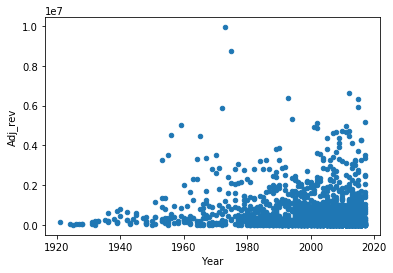

In [41]:
df_train_miss.plot.scatter(x='Year', y='Adj_rev')

We see revenue has been increasing over time, with outliers in the 1970s, one of which corresponds to Spielberg's Jaws.  How about the relationship between budget and revenue? 

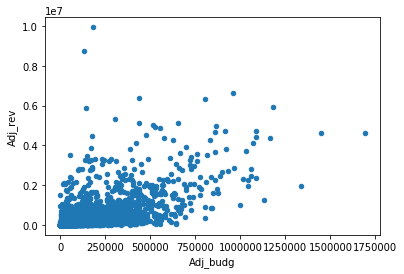

In [43]:
#relationship between budget and revenue
df_train_miss.plot.scatter(x='Adj_budg', y='Adj_rev')

It aappears there's an increasing relationship between budget and revenue, although there are extreme outliers on the right(which correspond to films in the Pirates of the Caribbean franchise).  I'll look the plot again without those films.  

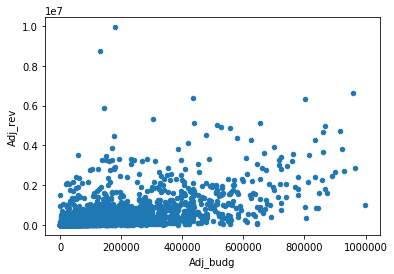

In [44]:
#relationship between budget and revenue
df_train_miss[df_train_miss['Adj_budg']<=1000000].plot.scatter(x='Adj_budg', y='Adj_rev')

In [492]:
np.corrcoef(df_train_miss['Adj_budg'], df_train_miss['Adj_rev'])

array([[ 1.        ,  0.61301375],
       [ 0.61301375,  1.        ]])

Indeed, we can see a correlation of .61 between the budget and revenue variables, which intuitively is not surprising.
we can see that there is much in the revenue data that cannot be explained by budget alone.  Big budget films may generate higher revenue for a variety of reasons. They are more widely advertised, widely distributed and can afford to include popular movie stars in the cast.  Lower-budget indie films will generally have less star power, less robust distribution, and as a result, a smaller audience reach. 

In general what do the distributions of revenue and budget look like?

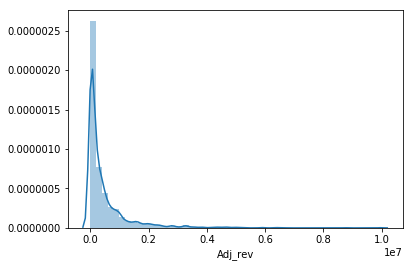

In [46]:
sb.distplot(df_train_miss["Adj_rev"].dropna())

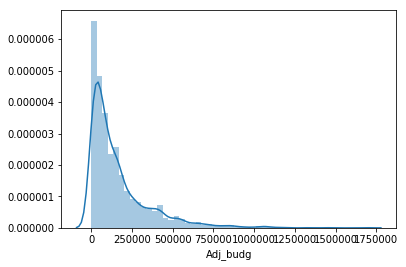

In [45]:
sb.distplot(df_train_miss["Adj_budg"].dropna())

They are both right-skewed distributions, which is not surprising.  Of course, they are both bounded by zero and we expect some huge block-buster films to pull away from the rest, though they are fairly rare.  

Now that revenue and budget have been looked at, what other variables in the dataset could be of use? 

# Crew

One issue with the dataset is that many of the columns listed below as 'object', like crew and belongs_to_collection,contain dictionaries embedded in strings.  Using the ast package, this data can be parsed and flattened.

I'll first transform the crew and cast columns into lists of dicts.  This is much easier to work with for feature engineering and modeling.  The code below converts the columns from strings to lists of dicts, which makes it much easier to pull out information.  

In [495]:
df_train.loc[df_train["cast"].notnull(),"cast"]=df_train.loc[df_train["cast"].notnull(),"cast"].apply(lambda x : ast.literal_eval(x))
df_train.loc[df_train["crew"].notnull(),"crew"]=df_train.loc[df_train["crew"].notnull(),"crew"].apply(lambda x : ast.literal_eval(x))
df_test.loc[df_test["cast"].notnull(),"cast"]=df_test.loc[df_test["cast"].notnull(),"cast"].apply(lambda x : ast.literal_eval(x))
df_test.loc[df_test["crew"].notnull(),"crew"]=df_test.loc[df_test["crew"].notnull(),"crew"].apply(lambda x : ast.literal_eval(x))

Crew has a huge amount of distinct jobs, but I don't think all of them make sense to consider when modeling.  It's possible that crew size, which can be seen as a proxy for budget, is useful.  In addition, if films have well-known directors, producers or writers, they may be more likely to earn higher revenue.  

Below, I look at some aspects of the crew column and create a few new columns from this data.  

In [496]:
#Code to get unique crew jobs
s=set()
i=0
for list_obj in df_train["crew"].dropna():
    for dict_obj in list_obj:
        s.add(dict_obj['job'])   
crew_list = list(s)

In [497]:
#Code to get unique crew jobs
s=set()
i=0
for list_obj in df_test["crew"].dropna():
    for dict_obj in list_obj:
        s.add(dict_obj['job'])   
crew_list_2 = list(s)

In [498]:
print(len(crew_list), len(crew_list_2))

412 420


In [499]:
df_test.shape

(4398, 34)

So, there are 412 different crew jobs listed in the train data and 420 in the test data.  From these, I'll specifically pull out directors, producers and writers.  In addition, I'll look at other crew_attributes (gender distribution, size) to see if they correlate with revenue.  

In [500]:
#Get crew count for each film
df_train["crew_ct"]= df_train["crew"].apply(lambda x: len(x) if type(x)==list else 0)
df_test["crew_ct"] = df_test["crew"].apply(lambda x: len(x) if type(x)==list else 0)

In [501]:
#summary stats and distribution of crew_ct
print(df_train['crew_ct'].describe(), df_test['crew_ct'].describe())

count   2997.000
mean      24.380
std       28.060
min        0.000
25%        8.000
50%       14.000
75%       29.000
max      194.000
Name: crew_ct, dtype: float64 count   4398.000
mean      24.214
std       28.193
min        0.000
25%        8.000
50%       14.000
75%       28.000
max      182.000
Name: crew_ct, dtype: float64


There are no null values in the crew_ct column, but there are some 0's.  This doesn't make sense, so I suspect it's a missing data issue.  It's also evident that this is a right-skewed distribution with 75% of the data at or below 34, but with extreme outliers (max of 194) and the mean to the right of the median.  
As a quick-and-dirty way to fill in the gaps of crew_ct, I use the IMDB api to iterate over crew members found using the API.  The total count is returned and appended to crew_ct for the given film.  

In [502]:
##look at crews below 10, as this is near the 25% percentile after 0s are removed
zero_crew_train = df_train[df_train["crew_ct"]==0]['original_title'].tolist()
zero_crew_test = df_test[df_test["crew_ct"]==0]['original_title'].tolist()


In [503]:
print(len(zero_crew_train), len(zero_crew_test))

16 22


## Fill in gaps for crews.  

In [604]:
#instantaiate imdb class
import imdb
from imdb import IMDb
ia = imdb.IMDb()

In [262]:
##this function results in converting string to TitleCase
import re						# Import the regular expression library
Exclusions = [
	"a", "an", "the",																																							# Articles
	"and", "but", "or",  "by", "nor", "yet", "so",																								# Conjunctions
	"about", "above", "across", "after", "against", "along", "among", "around", "at", "before",		# Prepositions
	"behind", "between", "beyond", "but", "by", "concerning", "despite", "down", "during",
	"except", "following", "for", "from", "in", "including", "into", "like", "near", "of",
	"off", "on", "out", "over", "plus", "since", "through", "throughout", "to", "towards",
	"under", "until", "up", "upon", "with", "within", "without"
 ]
 
def TitleCase( curText: str ) -> str:
	""" Take a string and return it in a fashion that follows proper title case guidelines """
 
	outString = ""
	fragments = re.split( r'(\".*?\")|(\'.*?\')|(“.*?”)|(‘.*?’)', curText )		# Extract titles in quotation marks from string
 
	for fragment in fragments:																	# Treat and re-assemble all fragments
		if fragment:																							# skip empty matches generated by the OR in regex	
			fragString = ""
			tokens = fragment.split();															# Break string into individual words
 
			if tokens:
				for word in tokens:																		# Check each word
 
					punct = word[-1]																		# Check for trailing punctuation mark
					if punct.isalpha():
						punct = ""
					else:
						word = word[:-1]
 
					if word.lower() in Exclusions:											# if it is excluded,
						fragString += word.lower() + punct + " "					# make it lowercase
					else:																								# otherwise,
						fragString += word.capitalize() + punct + " "			# capitalize it
 
				cap = 1
				if not fragString[0].isalpha():
					cap = 2
 
				outString += ( fragString[:cap].upper() + fragString[cap:]).strip() + " "
 
	return (outString[:1].upper() + outString[1:]).strip()			# Capitalize first letter and strip trailing space

In [260]:
exclude = ['plot outline', 'sound mix', 'languages', 'country codes', 'votes', 'production companies', 'box office', 'countries',
          'special effects companies', 'kind', 'akas', 'original air date', 'genres', 'certificates', 'language codes', 'year', 
           'thanks', 'aspect ratio', 'title', 'color info', 'runtimes', 'cover url', 'distributors', 'rating','seasons','']
#fuction to return crew_ct
def get_crew_ct(movie):    
    ct=0
    match = ia.get_movie(movie)
    title = match['title']  
    for list_obj in match.infoset2keys['main']:
        if list_obj not in exclude and isinstance(match[list_obj], list):
    #gets list of positions that match the positions in original crew_list
            l = [TitleCase(item.notes) for item in match[list_obj] if TitleCase(item.notes) in crew_list]
            ct+= len(l)
    return(title,ct)

In [263]:
movie_list=[]

for movie in low_crew:
    try:
        movie = ia.search_movie(movie)[0].getID()
        title, ct = get_crew_ct(movie)
        movie_list.append([movie, title, ct])
    except (AttributeError, ValueError, IndexError) as ex:
        pass
# , IMDbDataAccessError 

In [265]:
##MOVIE_LISTT
crew_ct_df = pd.DataFrame.from_records(movie_list, columns =['ID', 'Title', 'Ct'])

In [266]:
crew_ct_df.to_csv('crew_ct_df.csv')

In [268]:
##can add to previous df full df_train
df_train_miss = pd.merge(df_train_miss, crew_ct_df, how='left',
        left_on=['original_title'], right_on='Title')

In [272]:
df_train_miss['crew_ct']= df_train_miss.apply(lambda row: row['Ct'] if pd.isnull(row['Ct'])==False else row['crew_ct'],
                                           axis=1)

In [275]:
df_train_miss.drop(columns=['ID', 'Title', 'Ct', 'Unnamed: 0', 'Unnamed: 0.1','Unnamed: 0.1.1'
                                    , 'Unnamed: 0.1.1.1'], inplace=True)

In [679]:
###now look at crew_ct again
#summary stats and distribution of crew_ct
print(df_train_miss['crew_ct'].isna().sum())
df_train_miss["crew_ct"].describe()

0


count   2353.000
mean      27.583
std       29.967
min        0.000
25%        9.000
50%       16.000
75%       34.000
max      194.000
Name: crew_ct, dtype: float64

Now we see a huge outlier, which happens to be The Dark Knight rises. 7 films with 0 crews logged.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


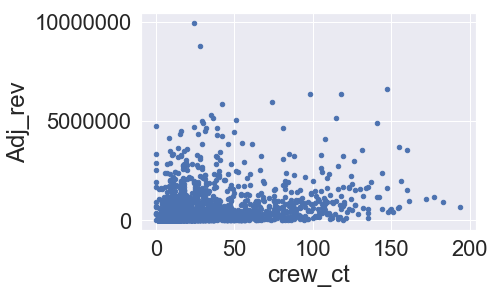

In [829]:
##is there a relationship between crew size and revenue?
df_train_miss[df_train_miss['crew_ct']<300].plot(x='crew_ct', y='Adj_rev', kind='scatter')
plt.ticklabel_format(style='plain')

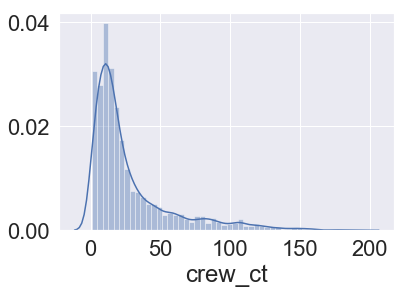

In [830]:
# look more at the crew_ct those without 0s
sb.distplot(df_train_miss[df_train_miss["crew_ct"]!=0]['crew_ct'])

We can also pull out important crew members like Director, Writer and Producer

In [932]:
df_train_miss['Director'] = df_train_miss["crew"].apply(lambda x: [d['name'] for d in x if d['job']=='Director'] if isinstance(x,list) else [])
df_test_miss['Director'] = df_test_miss["crew"].apply(lambda x: [d['name'] for d in x if d['job']=='Director']if(isinstance(x,list) and len(x)>0) else [])

df_train_miss['Writer'] = df_train_miss["crew"].apply(lambda x: [d['name'] for d in x if d['job']=='Writer'] if isinstance(x,list) else [])
df_test_miss['Writer'] = df_test_miss["crew"].apply(lambda x: [d['name'] for d in x if d['job']=='Writer'] if isinstance(x,list) else [])

df_train_miss['Producer'] = df_train_miss["crew"].apply(lambda x: [d['name'] for d in x if d['job']=='Producer'] if isinstance(x,list) else [])
df_test_miss['Producer'] = df_test_miss["crew"].apply(lambda x: [d['name'] for d in x if d['job']=='Producer'] if isinstance(x,list) else [])


/Users/samuelcolon/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/samuelcolon/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/samuelcolon/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [832]:
#df_train_miss['Writer'].replace({'[]': None}, inplace=True)
df_train_miss.Writer = df_train_miss.Writer.apply(lambda x: np.nan if len(x)==0 else x)
df_train_miss.Director = df_train_miss.Director.apply(lambda x: np.nan if len(x)==0 else x)
df_train_miss.Producer = df_train_miss.Producer.apply(lambda x: np.nan if len(x)==0 else x)

/Users/samuelcolon/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [933]:
#df_train_miss['Writer'].replace({'[]': None}, inplace=True)
df_test_miss.Writer = df_test_miss.Writer.apply(lambda x: np.nan if len(x)==0 else x)
df_test_miss.Director = df_test_miss.Director.apply(lambda x: np.nan if len(x)==0 else x)
df_test_miss.Producer = df_test_miss.Producer.apply(lambda x: np.nan if len(x)==0 else x)

/Users/samuelcolon/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Some movies might have two directors, two writers, producres, etc

In [934]:
df_train_miss[["original_title", "Director", "Writer", "Producer"]].isna().sum()
df_test_miss[["original_title", "Director", "Writer", "Producer"]].isna().sum()

original_title       0
Director            18
Writer            2362
Producer           559
dtype: int64

## Crew gender distribution

In [935]:
df_train_miss["crew_gender_unspec"]= df_train_miss[~df_train_miss["crew"].isnull()]["crew"].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
df_train_miss["crew_gender_fem"]= df_train_miss[~df_train_miss["crew"].isnull()]["crew"].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
df_train_miss["crew_gender_male"]= df_train_miss[~df_train_miss["crew"].isnull()]["crew"].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

df_test_miss["crew_gender_unspec"]= df_test_miss[~df_test_miss["crew"].isnull()]["crew"].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
df_test_miss["crew_gender_fem"]= df_test_miss[~df_test_miss["crew"].isnull()]["crew"].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
df_test_miss["crew_gender_male"]= df_test_miss[~df_test_miss["crew"].isnull()]["crew"].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

/Users/samuelcolon/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/samuelcolon/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/samuelcolon/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Rather than looking at raw counts, it's more instructive to look at the proportions gender distribution.

In [936]:
df_train_miss['prop_male'] = df_train_miss['crew_gender_male']/df_train_miss['crew_ct']
df_train_miss['prop_fem'] = df_train_miss['crew_gender_fem']/df_train_miss['crew_ct']
df_train_miss['prop_unspec'] = df_train_miss['crew_gender_unspec']/df_train_miss['crew_ct']

df_test_miss['prop_male'] = df_test_miss['crew_gender_male']/df_test_miss['crew_ct']
df_test_miss['prop_fem'] = df_test_miss['crew_gender_fem']/df_test_miss['crew_ct']
df_test_miss['prop_unspec'] = df_test_miss['crew_gender_unspec']/df_test_miss['crew_ct']

df_train_miss= df_train_miss.drop(columns=["crew_gender_unspec", "crew_gender_fem", "crew_gender_male"])
df_test_miss = df_test_miss.drop(columns=["crew_gender_unspec", "crew_gender_fem", "crew_gender_male"])

/Users/samuelcolon/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/samuelcolon/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/samuelcolon/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Is there any relationhip between gender breakdowns and revenue? Or, do we see changes in gender breakdowns over time?

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


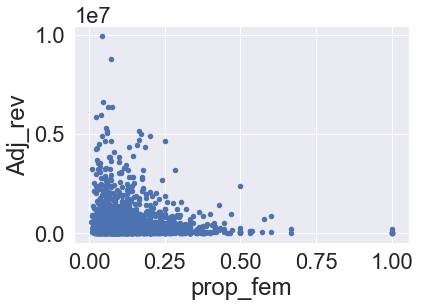

In [937]:
df_train_miss[df_train_miss['prop_fem']!=0].plot(x='prop_fem', y='Adj_rev', kind='scatter')

In [938]:
df_train_miss[df_train_miss['prop_fem']>.55]['original_title']

83                                 Silent House
568                        Bridget Jones's Baby
653                                     Whip It
669                      A Little Bit of Heaven
1061                              The Romantics
1324                      But I'm a Cheerleader
1356                                  The Women
1389    The Sisterhood of the Traveling Pants 2
1419                         Behind the Burly Q
1749                               Three Wishes
1854                                      Aloft
1921                The Ballad of Jack and Rose
2762                           Music and Lyrics
Name: original_title, dtype: object

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


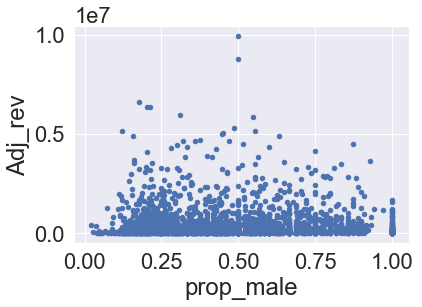

In [837]:
df_train_miss[df_train_miss['prop_male']!=0].plot(x='prop_male', y='Adj_rev', kind='scatter')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


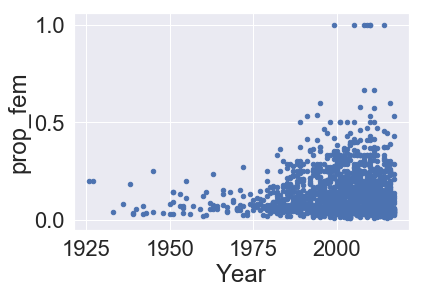

In [690]:
df_train_miss[df_train_miss['prop_fem']!=0].plot(x='Year', y='prop_fem', kind='scatter')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


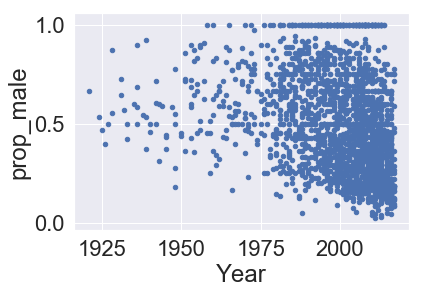

In [691]:
df_train_miss[df_train_miss['prop_male']!=0].plot(x='Year', y='prop_male', kind='scatter')

In [939]:
np.corrcoef(x=df_train_miss[df_train_miss['crew_ct'].isnull()==False]['crew_ct'], 
            y= df_train_miss[df_train_miss['crew_ct'].isnull()==False]['Adj_rev'])

array([[ 1.        ,  0.28857206],
       [ 0.28857206,  1.        ]])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


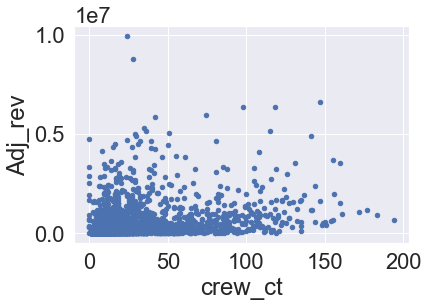

In [693]:
df_train_miss[df_train_miss['crew_ct'].isnull()==False].plot(x='crew_ct', y='Adj_rev', kind='scatter')

## In Collection

We see that some movies are listed as belonging to collections.  We can create a new variable to separate out such films.  

In [506]:
df_train['In_Collection']= np.where(df_train['belongs_to_collection'].isnull()==True, 1, 0)
df_test['In_Collection']= np.where(df_test['belongs_to_collection'].isnull()==True, 1, 0)

Text(0.5, 1.0, 'Films in Collections')

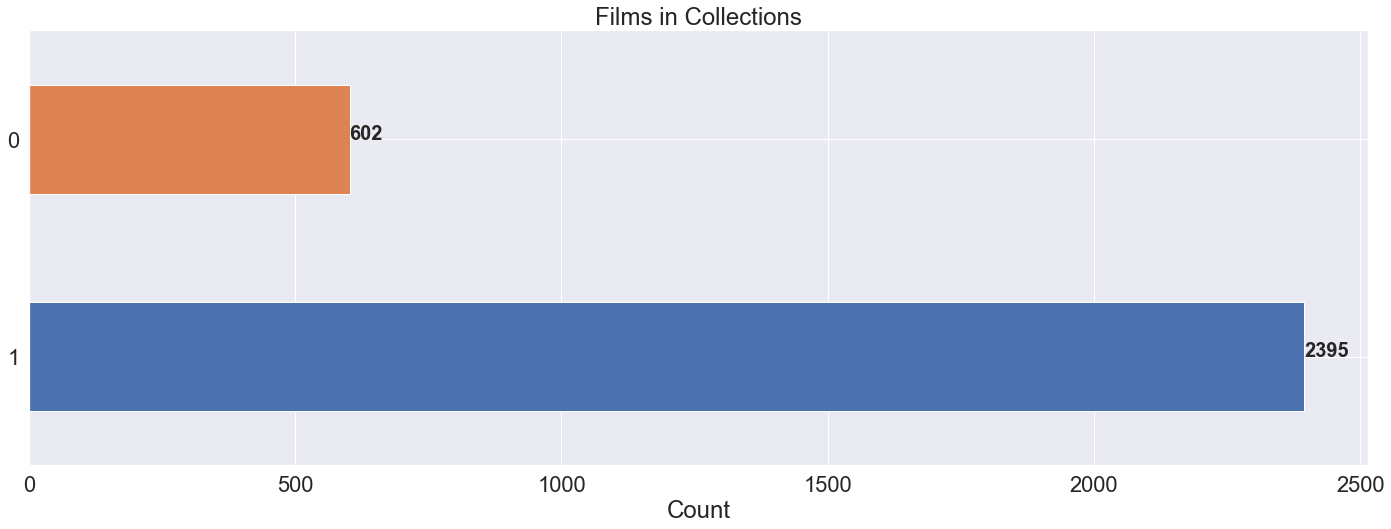

In [508]:
df_train['In_Collection'].value_counts().plot(kind="barh", figsize = (24,8))
for i, v in enumerate(df_train['In_Collection'].value_counts()):
    plt.text(v, i, str(v), fontweight='bold', fontsize = 20)
plt.xlabel("Count")
plt.title("Films in Collections")

Approximately 20% of the training set movies are part of a collection.  Does it have an effect on adjusted revenue?

Let's look at the distribution of the revenue for movies based on membership in a collection

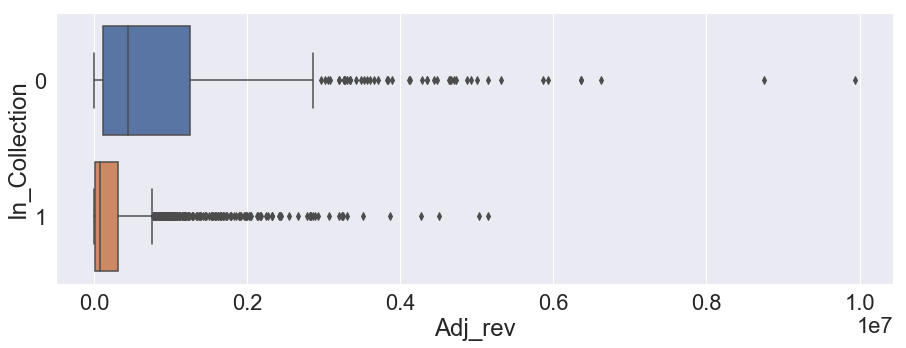

In [509]:
plot_dims = (15, 5)
fig, ax = plt.subplots(figsize=plot_dims)
sb.boxplot(ax=ax, y="In_Collection", x="Adj_rev", data=df_train, orient="h")

Movies in collections tend to have higher revenue.  This is intuitive, as it's natural for producers of high-grossing movies, like Mission Impossible Fast and the Furious, and Pirates of the Carribean to want to produce continuing sequels if the original was high-grossing.  This is a phenomenon worth keeping in the mind for the final analysis.  

### Languages

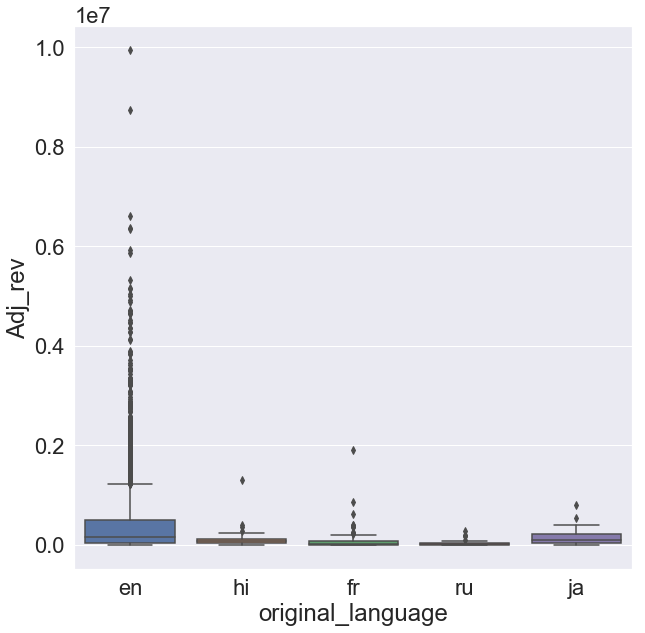

In [510]:
top_lang_df = df_train[df_train['original_language'].isin(['en','fr', 'hi','ru','ja'])] ##check that it's top
plot_dims = (10, 10)
fig, ax = plt.subplots(figsize=plot_dims)
sb.boxplot(ax=ax, y="Adj_rev", x="original_language", data=top_lang_df)


Clearly films in english generate the move revenue.  It might be worth creating a dummy variable for this field, those with English as their original language and those without, because once you move away from the top 10 languages, the categories become very sparse.  

In [511]:
df_train['Is_Eng'] = df_train['original_language'].str.contains('en').astype(int)
df_test['Is_Eng'] = df_test['original_language'].str.contains('en').astype(int)

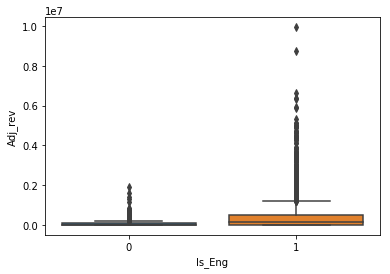

In [380]:
sb.boxplot(y="Adj_rev", x="Is_Eng", data=df_train)

# Genres

Some movies have multiple genres, and 7 have no genre listed at all.

In [512]:
df_train = df_train.reset_index()
df_train.loc[df_train["genres"].notnull(),"genres"]=df_train.loc[df_train["genres"].notnull(),"genres"].apply(lambda x : ast.literal_eval(x))

df_test= df_test.reset_index()
df_test.loc[df_test["genres"].notnull(),"genres"]=df_test.loc[df_test["genres"].notnull(),"genres"].apply(lambda x : ast.literal_eval(x))

In [513]:
df_train["genre_ct"]= df_train["genres"].apply(lambda x: len(x) if type(x)==list else 0)
df_test["genre_ct"]= df_test["genres"].apply(lambda x: len(x) if type(x)==list else 0)

In [514]:
#cite link https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation
df_train['all_genres'] = df_train['genres'].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if type(x)==list else ' ')

In [515]:
df_test['all_genres'] = df_test['genres'].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if type(x)==list else ' ')

In [516]:
#df_train["genres"][1]
genre_list = list(df_train["genres"].apply(lambda x: [el["name"] for el in x] if type(x)==list else []).values)
genre_list = np.unique(list(chain.from_iterable(genre_list)))

In [390]:
genre_list

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], 
      dtype='<U15')

In [397]:
df_train.drop(columns=['level_0'],inplace=True)
df_train.columns  ##drop level 0 , ##adj_rev, 

Index(['index', 'id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'Year', 'Month', 'Day', 'Domestic_Gross', 'Worldwide_Gross',
       'num_title', 'Match_Score', 'movie', 'year', 'Annual_Avg',
       'Annual_Percent_Change', 'Adj_rev', 'Adj_budg', 'crew_ct',
       'In_Collection', 'Is_Eng', 'genre_ct', 'all_genres'],
      dtype='object')

In [517]:
##dummies for the genre columns dummy!
for g in genre_list:
    df_train['genre_' + g] = df_train['all_genres'].apply(lambda x: 1 if g in x else 0)

In [518]:
##dummies for the genre columns
for g in genre_list:
    df_test['genre_' + g] = df_test['all_genres'].apply(lambda x: 1 if g in x else 0)

So, we see that dramas and comedies are the most prevalent genres in the training set.  Now, let's look at the distribution of revenue across genres.  

## Last Df_test_miss

In [520]:
genre_df = pd.DataFrame(df_train.all_genres.str.split(',').tolist(), index=df_train.Adj_rev).stack()

In [16]:
def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

In [ ]:
genre_yr_df = tidy_split(df_train[['Year','Adj_rev','all_genres']],'all_genres', sep=",")

In [522]:
genre_df = genre_df.reset_index([0, 'Adj_rev'])

In [523]:
genre_df.rename(columns={0: 'genre'},inplace=True)

Text(0, 0.5, 'REVENUE')

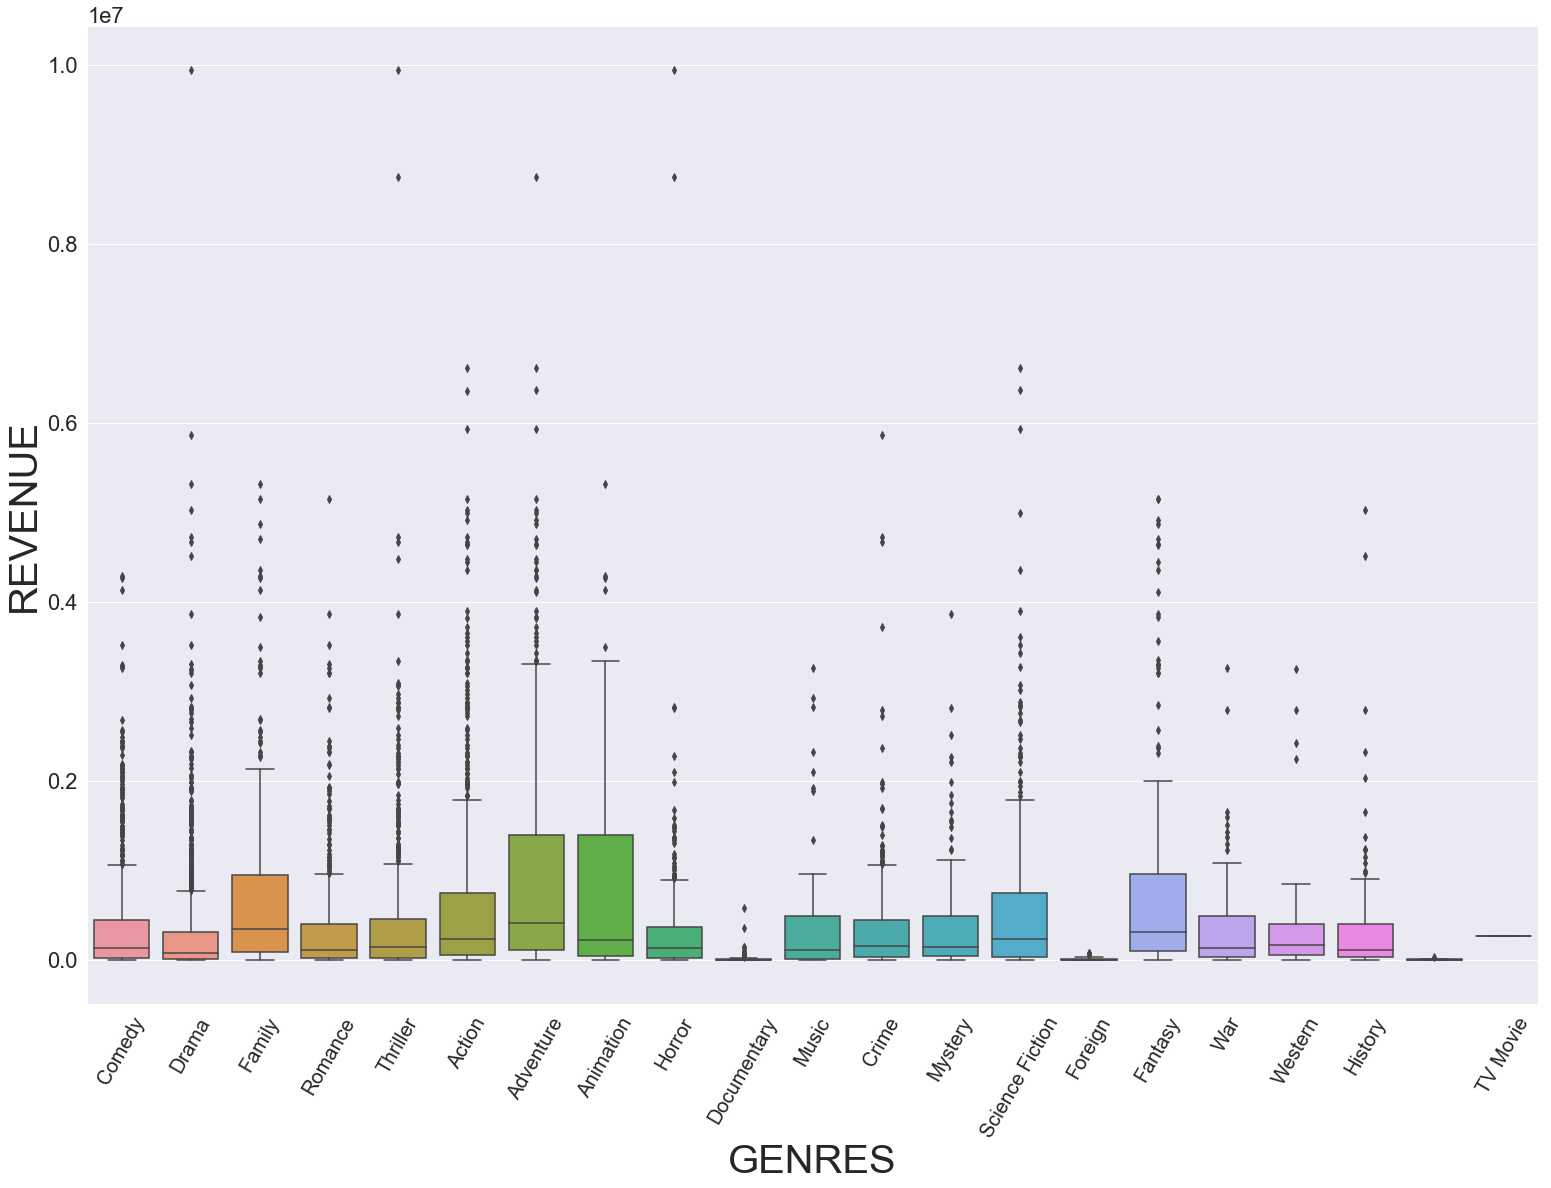

In [524]:
plt.figure(figsize=(26,18))
sb.set(font_scale=2)
b = sb.boxplot(x="genre", y="Adj_rev", data=genre_df)
#b.set_xticklabels(fontsize=25, rotation = 40)
b.set_xticklabels(b.get_xticklabels(), fontsize=20, rotation = 60)
#b.set_yticklabels(fontsize=20)
plt.xlabel("GENRES", fontsize=40)
plt.ylabel("REVENUE", fontsize=40)

So, the genres with the highest adjusted revenue appear to be Adventure, Animation and Family on average.  The Foreign and Documentary genres fare particularly poorly.  

# Production Countries

In [525]:
#df_train_miss = df_train_miss.reset_index()
df_train.loc[df_train["production_countries"].notnull(),"production_countries"]=df_train.loc[df_train["production_countries"].notnull(),"production_countries"].apply(lambda x : ast.literal_eval(x))
df_test.loc[df_test["production_countries"].notnull(),"production_countries"]=df_test.loc[df_test["production_countries"].notnull(),"production_countries"].apply(lambda x : ast.literal_eval(x))

In [526]:
df_train['all_countries'] = df_train['production_countries'].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if type(x)==list else ' ')
df_test['all_countries'] = df_test['production_countries'].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if type(x)==list else ' ')

In [527]:
df_train['Prod_US'] = df_train['all_countries'].apply(lambda x: 1 if 'United States of America' in x else 0)
df_test['Prod_US'] = df_test['all_countries'].apply(lambda x: 1 if 'United States of America' in x else 0)

Text(0, 0.5, 'REVENUE')

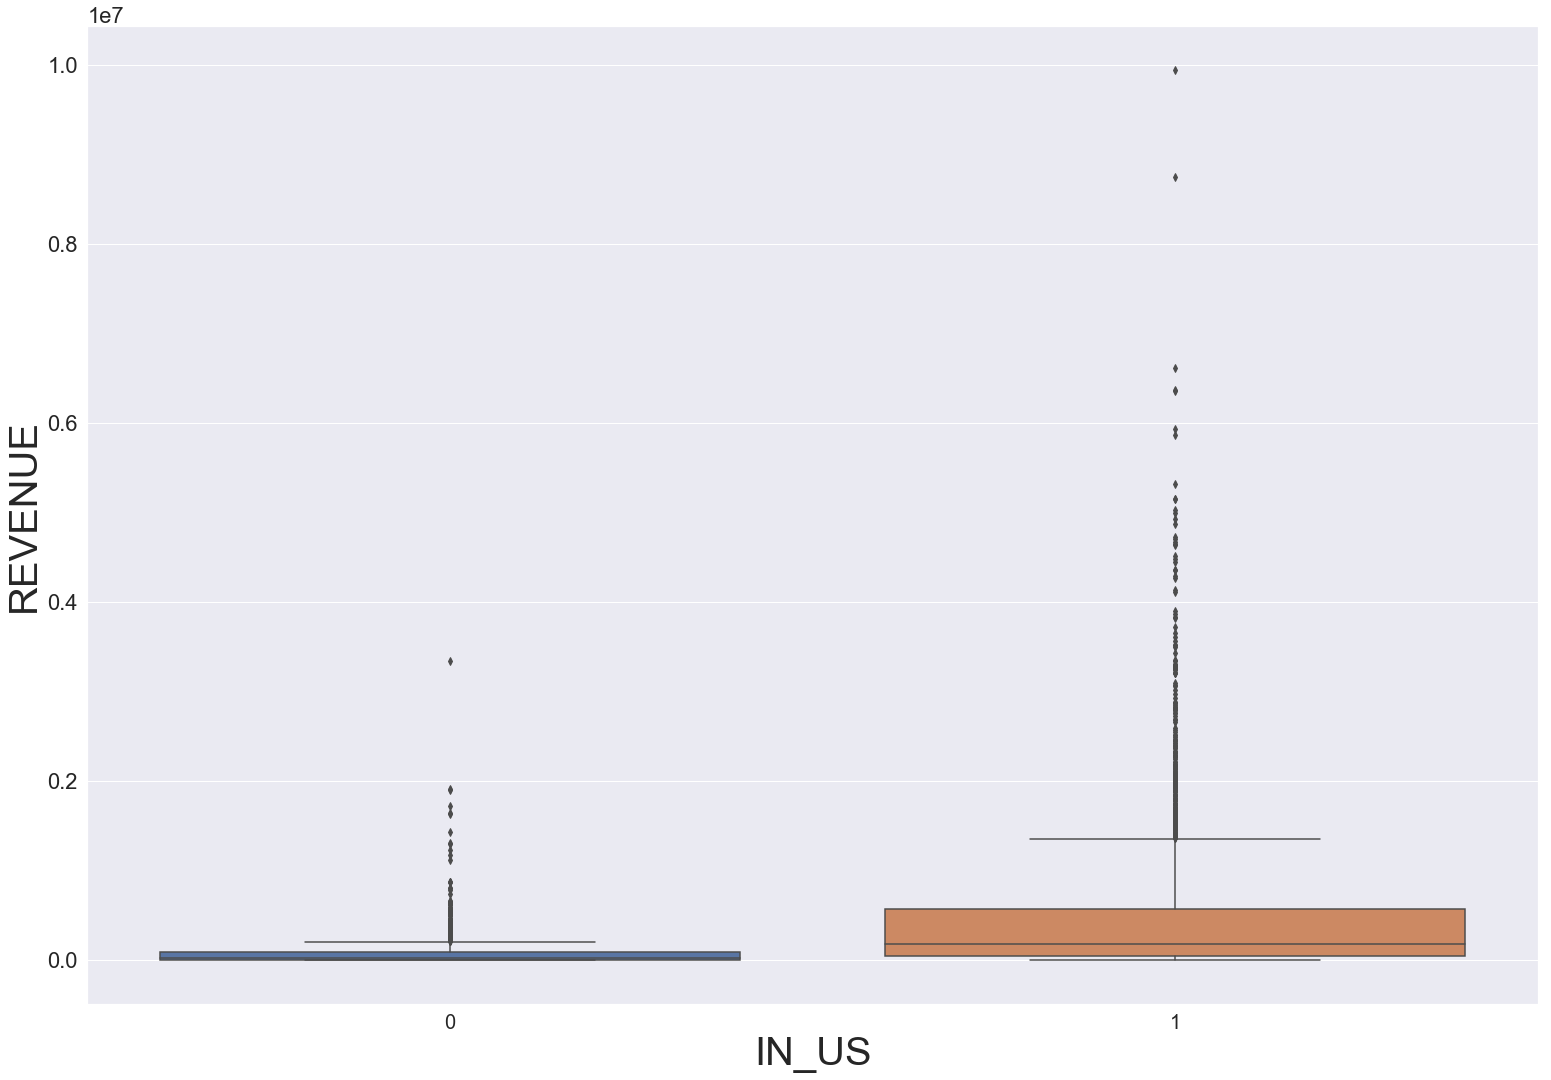

In [528]:
plt.figure(figsize=(26,18))
sb.set(font_scale=2)
b = sb.boxplot(x="Prod_US", y="Adj_rev", data=df_train)
#b.set_xticklabels(fontsize=25, rotation = 40)
b.set_xticklabels(b.get_xticklabels(), fontsize=20)
#b.set_yticklabels(fontsize=20)
plt.xlabel("IN_US", fontsize=40)
plt.ylabel("REVENUE", fontsize=40)

If any of the movie was shot in the US, the revenue is generally a lot higher.  #mean values per country?

Another categorical column we can analyze is the status column, which tells you if a movie was released 

# Status

In [867]:
df_train['status'].value_counts()

Released    2966
Rumored        4
Name: status, dtype: int64

Status is highly unbalanced, so I'll drop this column.  

In [959]:
df_train_miss.drop(columns=['status'], inplace=True)
df_test_miss.drop(columns=['status'], inplace=True)

# Popularity


While a formula for how this metric is calculated is not shown on TMDB, the documentation does list what features go into the calculation.  From the API documentation:

>Popularity is a very important metric here on TMDb. It helps us boost search results, adds an incredibly useful sort value for , and is also just kind of fun to see items chart up and down.

>Each model builds their popularity value slightly differently. If you're curious as to the how and why, check out the information below.

>Movies
Number of votes for the day
Number of views for the day
Number of users who marked it as a "favourite" for the day
Number of users who added it to their "watchlist" for the day
Release date
Number of total votes
Previous days score"


This information is worth keeping in mind during the analysis.  For now, let's look at the summary stats for popularity

In [868]:
pd.set_option("display.precision", 8)
df_train_miss['popularity'].describe()

count   2353.000
mean       9.517
std       13.315
min        0.002
25%        5.358
50%        8.172
75%       11.505
max      294.337
Name: popularity, dtype: float64

We see a min of 0.000001 and a max of 294.337037.  Perhaps if we look at these films individually, it may give us some insight into the popularity score.

In [759]:
df_train_miss.loc[df_train_miss['popularity']<.002,]['original_title']
df_train_miss.loc[df_train_miss['popularity']>294,]['original_title']

401    Wonder Woman
Name: original_title, dtype: object

So, given that the films are scored in popularity based on who marks it as a favorite, how much it's been viewed, and when it's been released, it's unsurprising that a recent high-grossing blockbuster like 'Wonder Woman' will have the highest popularity, while a film based on a Chekhov play is not popular.  So producers take note.  Comic book films make money, not Russian play adaptations.  

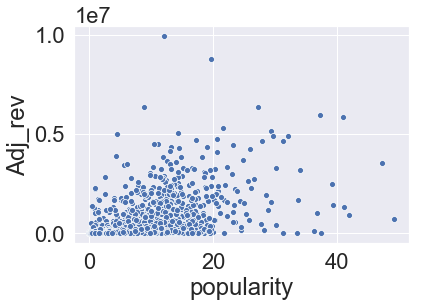

In [529]:
sb.scatterplot(x=df_train[df_train['popularity']<50]['popularity'], 
               y= df_train[df_train['popularity']<50]['Adj_rev'])                                                                                                     

After remove some large outliers on the right tail, a clear relationship between popularity and Adj_rev doesn't  appear.   

Still we see quite a lot of movies with high popularities but low revenues.  Let's try to find a few examples of those specific movies.  In particular, I'll look for movies with popularity greater than 9 and with revenue equal to or below the 20th percentile.

Two movies that fit this criteria are 'The Wild Bunch', the classic 1969 Sam Peckinpah Western, and Pollock, the biographical film of the 20th century painter, made in 2000.  It's unclear why these movies are high in the popularity ranks.  We'll have to dig deeper into the TMDB API to explore that.  What about movies with a low popularity and high revenue?

In [643]:
df_train[(df_train['popularity']<5) & (df_train['revenue']> 93000000)][0:5]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,id_x,belongs_to_collection,budget,genres,homepage,...,revenue,Year,Train_Name,Num_Name,Movie,Worldwide_Gross,Annual_Avg,Annual_Percent_Change,Adj_rev,Adj_budg
68,68,68,68,68,68,70,"[{'id': 9485, 'name': 'The Fast and the Furiou...",85000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thefastandthefurious3.com/,...,158468292.000,2006,NaN,NaN,NaN,nan,201.600,3.200,786053.036,421626.984
88,88,88,88,88,88,90,NaN,30000000,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,...,140081992.000,1993,NaN,NaN,NaN,nan,144.500,3.000,969425.550,207612.457
103,103,103,103,103,103,105,"[{'id': 131989, 'name': 'Recep İvedik Serisi',...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,...,149521495.000,2014,NaN,NaN,NaN,nan,236.700,1.600,631691.994,0.000
137,137,137,137,137,137,140,"[{'id': 748, 'name': 'X-Men Collection', 'post...",110000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",NaN,...,407711549.000,2003,NaN,NaN,NaN,nan,184.000,2.300,2215823.636,597826.087
173,173,173,173,173,173,176,"[{'id': 9485, 'name': 'The Fast and the Furiou...",38000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,...,207283925.000,2001,NaN,NaN,NaN,nan,177.100,2.800,1170434.359,214568.041


Here we some big-budget movies that done very poorly with critics(according to Rotten Tomatoes and metacritic), so perhaps critical acclaim play a big part in popularity score?  Again, looking at the data from TMDB's API may help clarify this.  

# Release Date

Movies are known to have specific cycles for release.  For example, those that are released prior to awards season, and those released after(throwaway films).  So let's see if there's a correlation between month of release and revenue.   

To convert the release_date variable from an object to a date, I used the functions from (cite) kernel.  

Before the conversion, I check for missing values in the training and test data, and find just one test observation with no release date.

In [530]:
def date_features(df):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_day'] = df['release_date'].dt.day
    df['release_quarter'] = df['release_date'].dt.quarter
    df.drop(columns=['release_date'], inplace=True)
    return df

In [531]:
df_train=date_features(df_train)
df_test=date_features(df_test)

In [532]:
def year_month_together(df):
    year = df["release_year"].astype(int).copy().astype(str)
    month=df['release_month'].astype(int).copy().astype(str)
    day=df['release_day'].astype(int).copy().astype(str) 
    df["release_date"]=  month.str.cat(day.str.cat(year,sep="/"), sep ="/") 
    df['release_date']=pd.to_datetime(df['release_date'],format="%m/%d/%Y")
    df['release_dow'] = df['release_date'].dt.dayofweek
    return df 

df_train=year_month_together(df_train)
df_test=year_month_together(df_test) #one null


0   2015-02-20
1   2004-08-06
2   2014-10-10
3   2012-03-09
4   2009-02-05
5   1987-08-06
6   2012-08-30
7   2004-01-15
8   1996-02-16
9   2003-04-16
Name: release_date, dtype: datetime64[ns]

With the variables transformed, there are many ways to slice the data.  Looking at the movie counts in the train and test data per decade, we see more recent movies are much more heavily represented. 

In [877]:
d1 = df_train_miss['release_date'].value_counts().sort_index()
d2 = df_test_miss['release_date'].value_counts().sort_index()

In [533]:
def floor_decade(date_value):
    ##"Takes a date. Returns the decade."
    return (date_value.year // 10) * 10

In [534]:
df_train['Decade'] = df_train['release_date'].map(floor_decade)
df_test['Decade'] = df_test['release_date'].map(floor_decade)

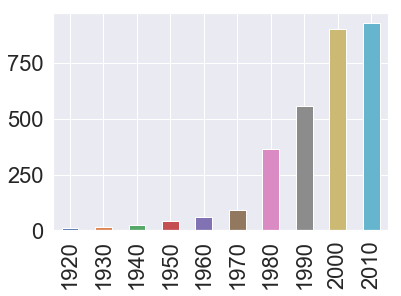

In [535]:
df_train['Decade'].value_counts(ascending=True).plot(kind="bar")

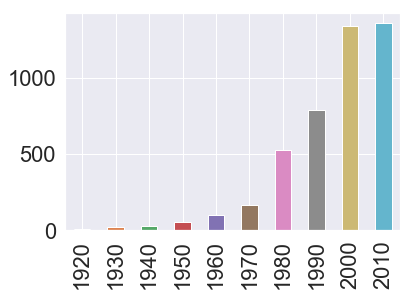

In [536]:
df_test['Decade'].value_counts(ascending=True).plot(kind="bar")

Most films in both the test and training sets are relatively recently released--the most being in our decade.  As there's a lot more data for recent films, I assume any prediction I run will do better on more recent films.  

Now can see if there are visible relationships between release_date and revenue, first using a boxplot of month vs revenue for the complete training set.

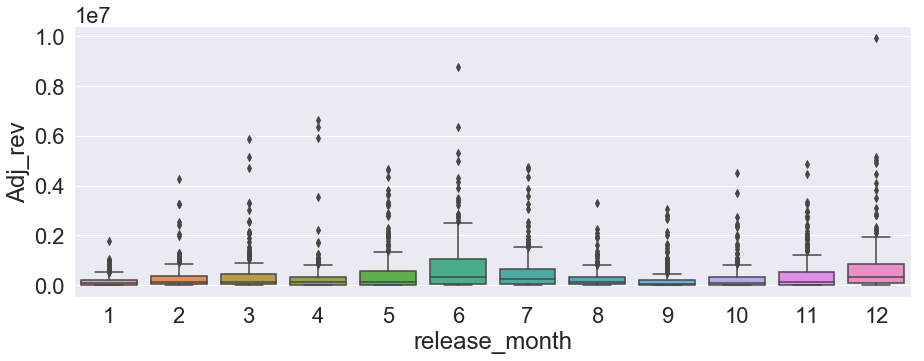

In [537]:
plot_dims = (15, 5)
fig, ax = plt.subplots(figsize=plot_dims)
sb.boxplot(ax=ax, x="release_month", y="Adj_rev", data=df_train)

It looks like the summer is the highest revenue release month.  Second is December which makes sense as holiday movies come out then.  

There's no easy trend to spot because outliers can have a huge effect on one year.  How about quarter?

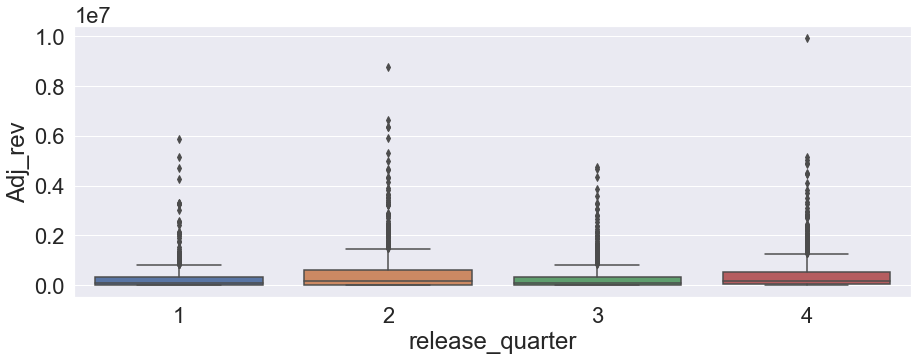

In [538]:
plot_dims = (15, 5)
fig, ax = plt.subplots(figsize=plot_dims)
sb.boxplot(ax=ax, x="release_quarter", y="Adj_rev", data=df_train)

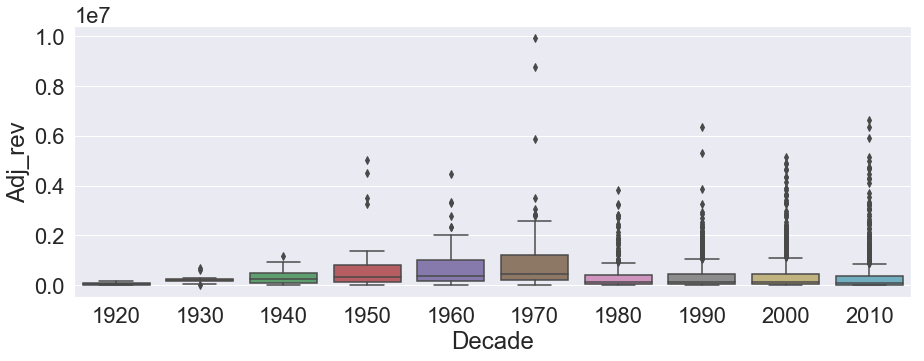

In [539]:
plot_dims = (15, 5)
fig, ax = plt.subplots(figsize=plot_dims)
sb.boxplot(ax=ax, x="Decade", y="Adj_rev", data=df_train)

Day of week?

Here we see the highest median revenue in November.  Perhaps there has been a median shift over time.  If so, what could account for this?  (Further investigation)

So, we see that both in the training set and the test set, the data is heavily skewed toward more recent movies.  We'll have to consider this fact in the analysis.  As the purpose of the model is to predict newly released movies revenue, it seems that the features of recent films should be much more important to our model.  

# Runtime

Logically, it wouldn't seem that runtime should have a positive linear relationship with revenue.  Most Hollywood movies are generally less than two hours, and it wouldn't do a director any good to extend a movie's running time in hopes of greater profit.

Let's look at the summary statistics and distribution

In [540]:
df_train['runtime'].describe()

count   2995.000
mean     107.834
std       22.085
min        0.000
25%       94.000
50%      104.000
75%      118.000
max      338.000
Name: runtime, dtype: float64

Something is wrong.  How can a film have a runtime of 0?  Let's look into that.  ??maybe impute?

In [610]:
df_train.loc[df_train['id'] == 391,'runtime'] = 86
df_train.loc[df_train['id'] == 978,'runtime'] = 93
df_train.loc[df_train['id'] == 1542,'runtime'] = 93
df_train.loc[df_train['id'] == 2151,'runtime'] = 108
df_train.loc[df_train['id'] == 2499,'runtime'] = 86
df_train.loc[df_train['id'] == 2866,'runtime'] = 96
df_train.loc[df_train['id'] == 1336,'runtime'] = 130

df_test.loc[df_test['id'] == 3244,'runtime'] = 93
df_test.loc[df_test['id'] == 4490,'runtime'] = 91
df_test.loc[df_test['id'] == 4633,'runtime'] = 100
df_test.loc[df_test['id'] == 6818,'runtime'] = 90


In [542]:
df_train[df_train['runtime']==0][['original_title','budget', 'revenue','id','runtime']]

,original_title,budget,revenue,id,runtime
587,А поутру они проснулись,0.000,234748,592,0.000
920,¿Quién mató a Bambi?,0.000,850259,925,0.000
1251,Cipolla Colt,0.000,39598448,1256,0.000
1875,Vermist,0.000,1125910,1875,0.000
2641,同桌的妳,0.000,76000000,2646,0.000
2781,Revelation,0.000,10000000,2786,0.000


In [543]:
df_test[df_test['runtime']==0][['original_title','budget']]

,original_title,budget
1073,Shikshanachya Aaicha Gho,380000.000
1221,Street Knight,0.000
1430,Плюс один,336029.000
2519,Glukhar v kino,2500000.000
2844,Frau Müller muss weg!,0.000
2848,Shabd,2500000.000
3209,Le dernier souffle,3800000.000
3803,Chaahat Ek Nasha...,0.000
4320,El truco del manco,0.000


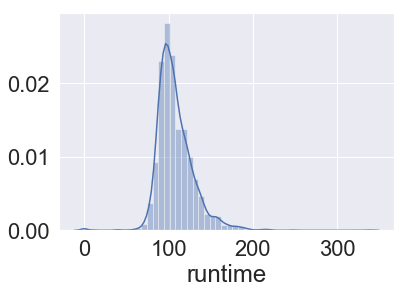

In [544]:
sb.distplot(df_train["runtime"].dropna())

As expected, the distribution's highest density is around the 90-120 minute range.  The longest in the list is a little over five-and-a-half hours.  It turns out this is actually the mini-series 'Carlos' by the French director Olivier Assayas.  The French are known for their long, langurous films (see Jacques Rivette)

Again though, we have a worrisome detail in the data.  Films with 0 runtimes.  Imagine, after having sat through the final preview, popcorn on lap, soda in hand, eyes fixed on the silver screen, and the theater's lights turn on.  Movie's over folks!  

Of course, these 0s are either data-entry errors or simply how the missing data is coded.  Let's see what movies have 0 runtimes to try and find out.

There are about 10 movies with a runtime less than 0.  That's clearly wrong, so I'll treat this as missing data.  This is a small amount of data, and I'd prefer to keep these values, so I'll fill them with the median.   

   The good news is that it's a small amount of the dataset, and it's possible we can find this information online.  As an exercise, let's run a simple scatterplot of the runtime vs. revenue.  I'll initially drop these rows, and then see if I can find the information online later.

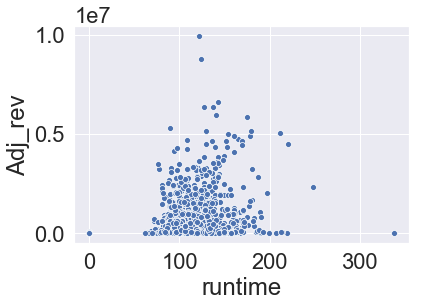

In [545]:
sb.scatterplot(x=df_train_miss['runtime'], y= df_train_miss['Adj_rev'])

We see that there's certainly no linear association between these variables. The highest grossing films seem to fall within that IQR that's balanced around 2 hours.  As you leave that sweet spot on both sides, revenue generally decreases. This could be useful in modeling--as we now know that longer isn't better, but the 1.5-2 hour sweet spot is indeed better.

#### Worst Performing Movies
What movies have the worst revenue to budget ratio?  

In [766]:
df_train_2 = df_train.copy()

In [768]:
df_train_2['profit_ratio'] = df_train_2['Adj_rev']/df_train_2['Adj_budg']

In [769]:
df_train_2010 = df_train_2[df_train_2['Decade']==2010]

In [770]:
df_train_2010_US = df_train_2010[df_train_2010['Prod_US']==1]

In [771]:
df_train_2010_US = df_train_2010_US[df_train_2010_US['budget']!=0]

In [772]:
df_train_2010_US.sort_values(by='profit_ratio', ascending=True)[['original_title','Adj_rev','Adj_budg','profit_ratio']].head()

,original_title,Adj_rev,Adj_budg,profit_ratio
130,The Good Doctor,23.148,26678.524,0.001
2199,Sweetwater,26.382,30042.918,0.001
2401,About Cherry,13.079,10888.502,0.001
934,Best Man Down,8.441,6533.101,0.001
2732,Extraction,70.781,50632.911,0.001


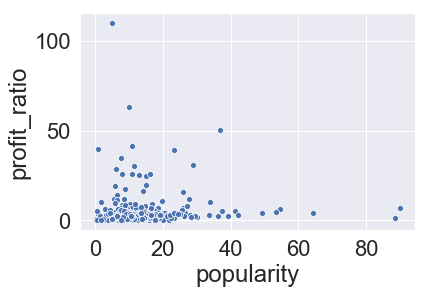

In [689]:
sb.scatterplot(x=df_train_2010_US[df_train_2010_US['popularity']<100]['popularity'],
               y=df_train_2010_US[df_train_2010_US['popularity']<100]['profit_ratio'])

In [690]:
genre_yr_US_df = tidy_split(df_train_2010_US[['Year','Adj_rev','all_genres', 'profit_ratio']],'all_genres', sep=",")

In [692]:
genre_yr_US_df.head()

,Year,Adj_rev,all_genres,profit_ratio
0,2015,51960.553,Comedy,0.880
2,2014,55310.520,Drama,3.967
6,2012,372151.895,Horror,6.103
6,2012,372151.895,Thriller,6.103
32,2015,619986.962,Action,1.633


Text(0, 0.5, 'REVENUE')

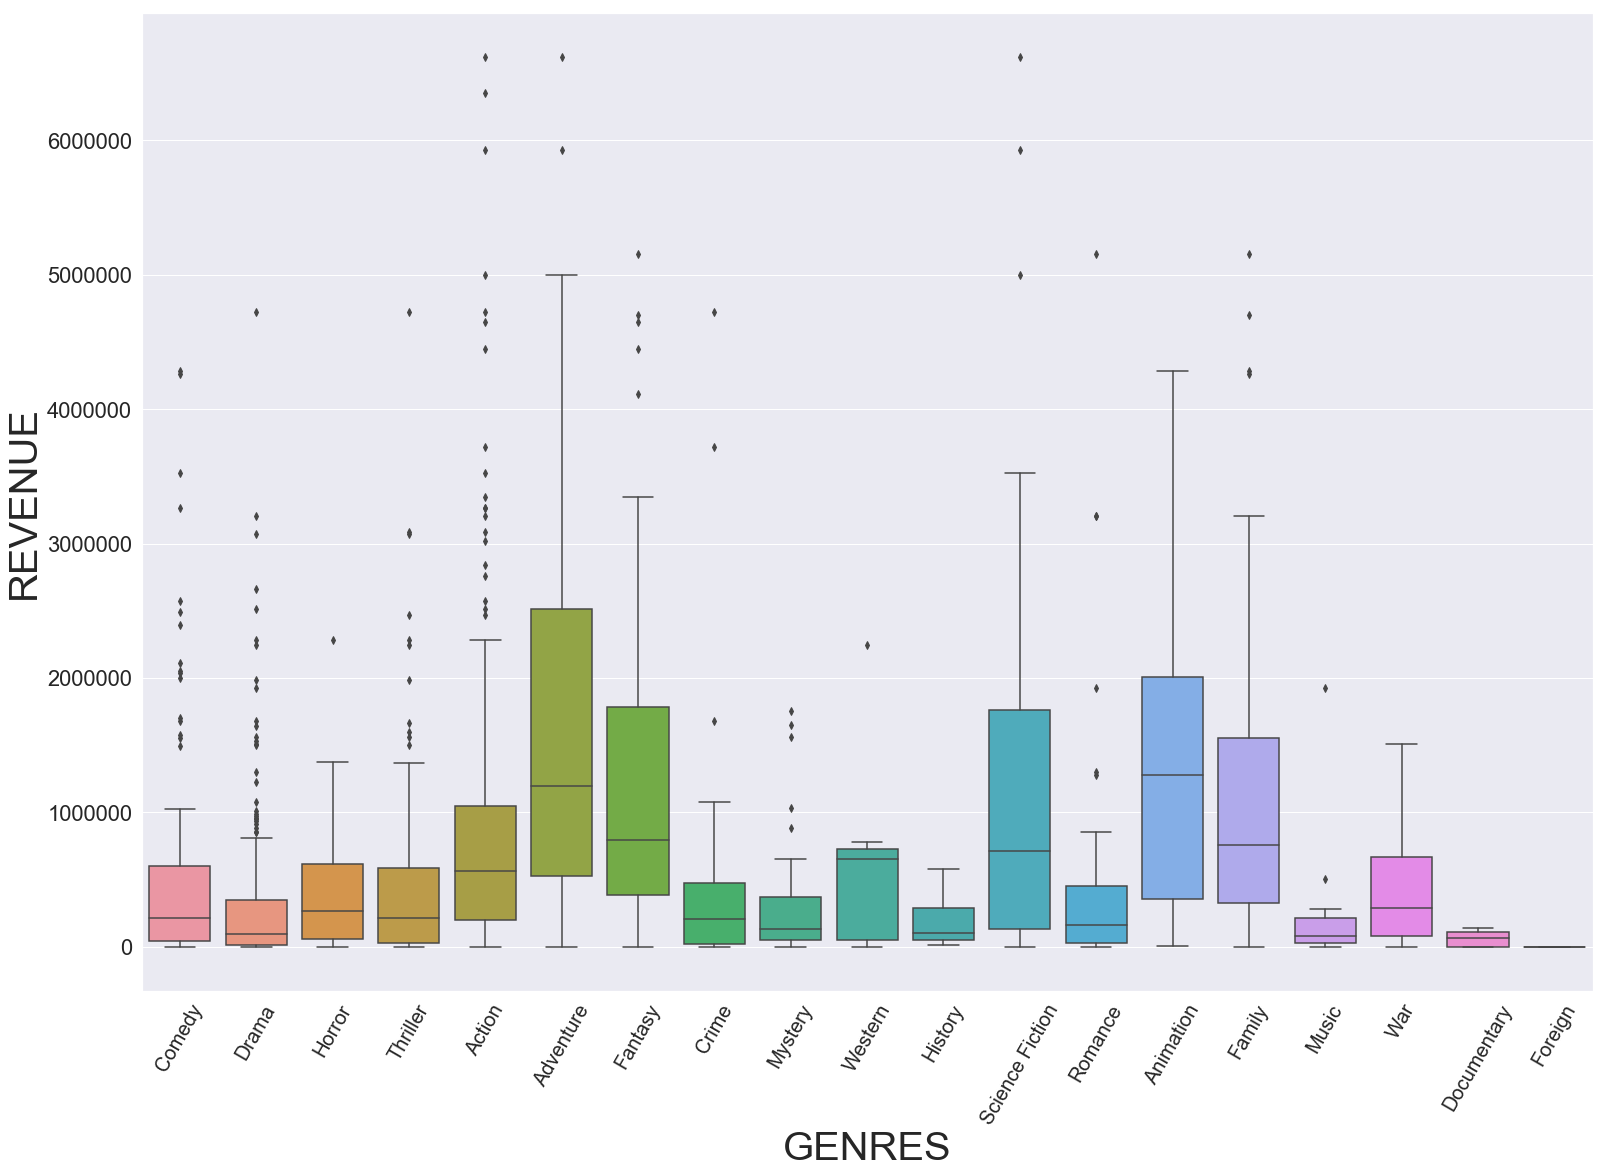

In [693]:
plt.figure(figsize=(26,18))
sb.set(font_scale=2)
b = sb.boxplot(x="all_genres", y="Adj_rev", data=genre_yr_US_df)
#b.set_xticklabels(fontsize=25, rotation = 40)
b.set_xticklabels(b.get_xticklabels(), fontsize=20, rotation = 60)
#b.set_yticklabels(fontsize=20)
plt.xlabel("GENRES", fontsize=40)
plt.ylabel("REVENUE", fontsize=40)

Text(0, 0.5, 'REVENUE')

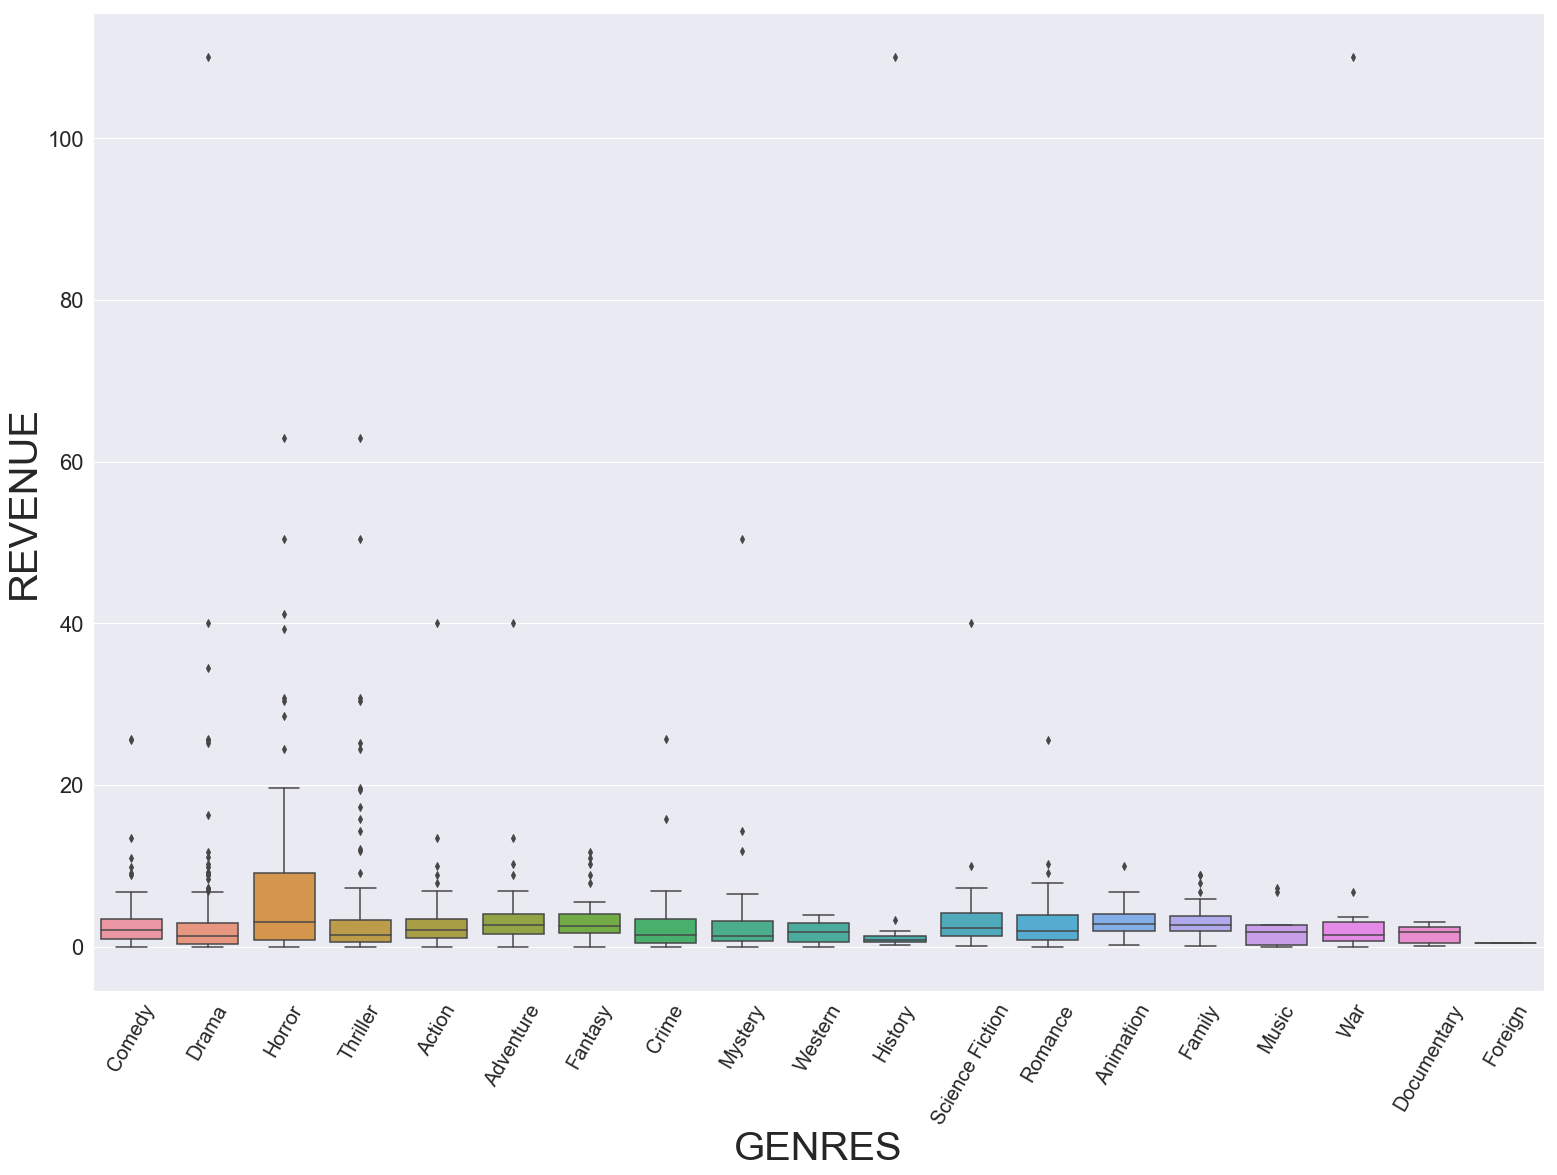

In [694]:
plt.figure(figsize=(26,18))
sb.set(font_scale=2)
b = sb.boxplot(x="all_genres", y="profit_ratio", data=genre_yr_US_df)
#b.set_xticklabels(fontsize=25, rotation = 40)
b.set_xticklabels(b.get_xticklabels(), fontsize=20, rotation = 60)
#b.set_yticklabels(fontsize=20)
plt.xlabel("GENRES", fontsize=40)
plt.ylabel("REVENUE", fontsize=40)

Horror the best for profit ratio or ROI.  Least investment needed for the most return.  

Animation and Adventure the best

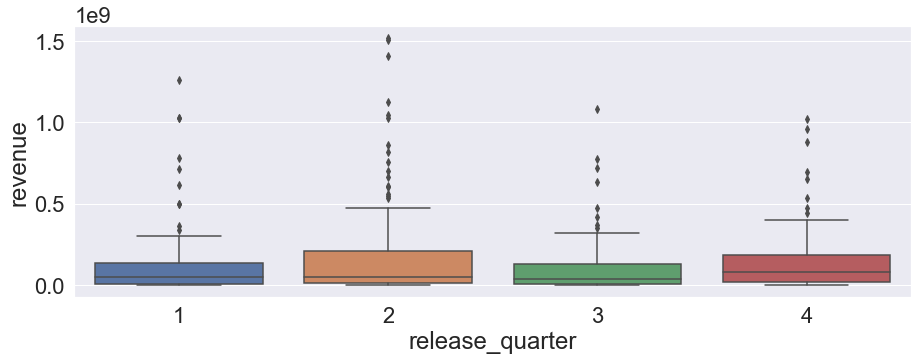

In [714]:
plot_dims = (15, 5)
fig, ax = plt.subplots(figsize=plot_dims)
sb.boxplot(ax=ax, x="release_quarter", y="revenue", data=df_train_2010_US)

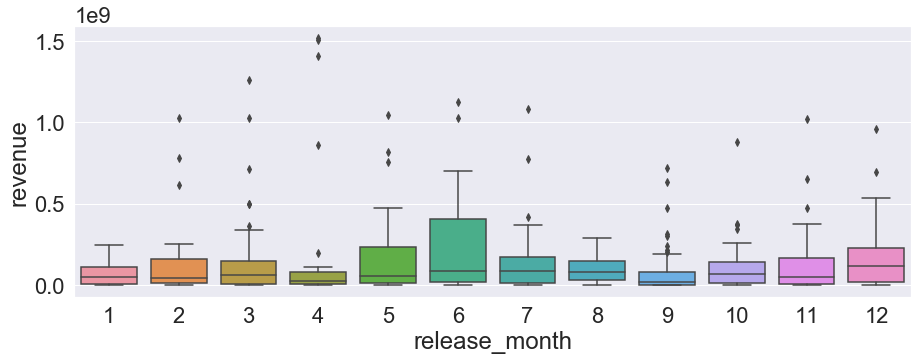

In [713]:
plot_dims = (15, 5)
fig, ax = plt.subplots(figsize=plot_dims)
sb.boxplot(ax=ax, x="release_month", y="revenue", data=df_train_2010_US)

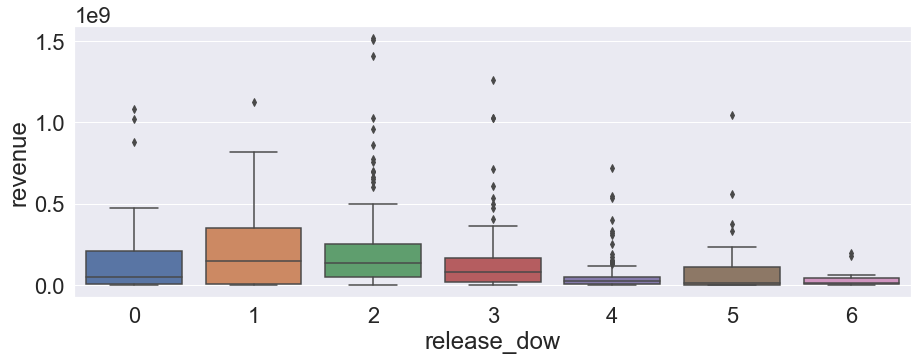

In [712]:
plot_dims = (15, 5)
fig, ax = plt.subplots(figsize=plot_dims)
sb.boxplot(ax=ax, x="release_dow", y="revenue", data=df_train_2010_US)

Early winter, dump months.  Summer blockbusters, holiday bump and oscar bait
“January is to film releasing roughly what the Bermuda Triangle is to navigation,” 

In [697]:
df_train_2010_US.loc[df_train_2010_US["Keywords"].notnull(),"Keywords"]=df_train_2010_US.loc[df_train_2010_US["Keywords"].notnull(),"Keywords"].apply(lambda x : ast.literal_eval(x))

In [778]:
df_train_2010_US["cast_ct"]= df_train_2010_US["cast"].apply(lambda x: len(x) if type(x)==list else 0)

In [787]:
df_train_2010_US[df_train_2010_US['cast_ct']<20][['original_title','cast_ct']]

,original_title,cast_ct
6,The Possession,14
34,Safe,15
46,The Hateful Eight,18
63,Nebraska,14
65,Henry's Crime,16
74,Fright Night,16
83,Silent House,6
132,Due Date,18
141,The Bronze,15
147,Dark Tide,9


In [784]:
df_train_2010_US[df_train_2010_US['title']=='Wonder Woman']['cast']

511    NaN
Name: cast, dtype: object

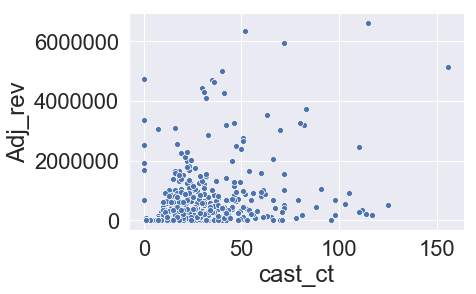

In [788]:
sb.scatterplot(x=df_train_2010_US['cast_ct'], y= df_train_2010_US['Adj_rev'])

In [755]:
movie_metadata['movie_title']= movie_metadata['movie_title'].apply(lambda x: x.replace(u'\xa0', u''))

### Production Companies

In [546]:
print(df_train.shape, df_test.shape)

(2997, 70) (4398, 68)


In [22]:
#df_train_miss.loc[df_train_miss["production_countries"].notnull(),"production_countries"]=df_train_miss.loc[df_train_miss["production_countries"].notnull(),"production_countries"].apply(lambda x : ast.literal_eval(x))
df_train.loc[df_train['production_companies'].notnull(),'production_companies']=df_train.loc[df_train['production_companies'].notnull(),'production_companies'].apply(lambda x : ast.literal_eval(x))
df_test.loc[df_test['production_companies'].notnull(),'production_companies']=df_test.loc[df_test['production_companies'].notnull(),'production_companies'].apply(lambda x : ast.literal_eval(x))

In [32]:
df_train['all_prod_cos'] = df_train['production_companies'].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if type(x)==list else ' ')
df_test['all_prod_cos'] = df_test['production_companies'].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if type(x)==list else ' ')

In [40]:
prod_co_df = tidy_split(df_train[['all_prod_cos', 'Adj_rev']],'all_prod_cos', sep=",")

In [41]:
top_10_prods = prod_co_df.groupby('all_prod_cos')['Adj_rev'].sum().sort_values(ascending=False)[0:10].index.tolist()

In [42]:
df_train['top_10_prods'] = df_train['all_prod_cos'].apply(lambda x: 1 if any (prod in x for prod in top_10_prods) else 0 )
df_test['top_10_prods'] = df_test['all_prod_cos'].apply(lambda x: 1 if any (prod in x for prod in top_10_prods) else 0 )

# Modeling

In [1204]:
df_modeling_train = df_train_miss.drop(columns=['Unnamed: 0', 'Unnamed: 0.1','Unnamed: 0.1.1','Unnamed: 0.1.1.1','Unnamed: 0.1.1.1.1',
                                          'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1','Unnamed: 0.1.1.1.1.1.1','cast',
                           'production_companies','spoken_languages','all_prod_cos', 'Worldwide_Gross',
                  'poster_path', 'imdb_id', 'homepage', 'release_date','Movie','Num_Name',
                    'release_dow','original_language', 'Producer', 'Writer', 'Director', 'Annual_Percent_Change', 'Annual_Avg',
                           'Year','genres','all_countries','Train_Name','crew', 'tagline', 'production_countries'
                           ,'overview', 'Keywords', 'all_genres', 'Adj_rev', 'index', 'belongs_to_collection','original_title'])

In [1205]:
df_modeling_test = df_test_miss.drop(columns=['Unnamed: 0', 'Unnamed: 0.1','Unnamed: 0.1.1','Unnamed: 0.1.1.1','Unnamed: 0.1.1.1.1',
                                          'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1','Unnamed: 0.1.1.1.1.1.1','cast',
                           'production_companies','spoken_languages','all_prod_cos', 'Worldwide_Gross',
                  'poster_path', 'imdb_id', 'homepage', 'release_date','Num_Name',
                    'release_dow','original_language', 'Producer', 'Writer', 'Director', 'Annual_Percent_Change', 'Annual_Avg',
                           'Year','genres','all_countries','Test_Name','crew', 'tagline', 'production_countries'
                           ,'overview', 'Keywords', 'all_genres', 'belongs_to_collection','Domestic_Gross','Month', 
                            'Day', 'index', 'title', 'original_title'])

In [611]:
##what variables need to be dropped??
df_train_modeling = df_train.copy()

In [612]:
df_test_modeling = df_test.copy()

In [614]:
df_train_modeling.drop(columns=['Day','homepage','imdb_id', 'id', 'original_language', 'original_title', 'overview',
                                'poster_path','cast','crew','Annual_Avg','Annual_Percent_Change','release_date', 'release_day',
                                'release_year','all_prod_cos','Domestic_Gross','Worldwide_Gross','num_title','title',
                                'tagline','Keywords','Match_Score','Month','Day','Year','year','movie','all_genres',
                                'genres', 'production_companies', 'production_countries','all_countries','status',
                               'index','Adj_rev','Adj_budg','belongs_to_collection','spoken_languages'],inplace=True)

In [615]:
df_test_modeling.drop(columns=['Day','homepage','imdb_id', 'id', 'original_language', 'original_title', 'overview',
                                'poster_path','cast','crew','Annual_Avg','Annual_Percent_Change','release_date', 'release_day',
                                'release_year','all_prod_cos','Domestic_Gross','Worldwide_Gross','num_title','title',
                                'tagline','Keywords','Match_Score','Month','Day','Year','year','movie','all_genres',
                                'genres', 'production_companies','belongs_to_collection', 'production_countries','all_countries','status',
                               'index','Adj_budg','spoken_languages'],inplace=True)

In [616]:
df_train_modeling.dtypes

budget                   float64
popularity               float64
runtime                  float64
revenue                    int64
crew_ct                    int64
In_Collection              int64
Is_Eng                     int64
genre_ct                   int64
genre_Action               int64
genre_Adventure            int64
genre_Animation            int64
genre_Comedy               int64
genre_Crime                int64
genre_Documentary          int64
genre_Drama                int64
genre_Family               int64
genre_Fantasy              int64
genre_Foreign              int64
genre_History              int64
genre_Horror               int64
genre_Music                int64
genre_Mystery              int64
genre_Romance              int64
genre_Science Fiction      int64
genre_TV Movie             int64
genre_Thriller             int64
genre_War                  int64
genre_Western              int64
Prod_US                    int64
release_month              int64
release_qu

In [617]:
df_train_modeling = pd.get_dummies(df_train_modeling, columns=['release_month', 'release_quarter','release_dow','Decade'])

In [618]:
df_test_modeling = pd.get_dummies(df_test_modeling, columns=['release_month', 'release_quarter','release_dow','Decade'])

## Random Forest

In [622]:
df_train_modeling.dropna(inplace=True)

In [623]:
X_train = df_train_modeling.drop(columns=['revenue'])
feature_list = list(X_train.columns)

In [624]:
y_train = np.array(df_train_modeling['revenue'])

In [625]:
## need to convert to np array?
X_train = np.array(X_train)

In [626]:
X_test = df_test_modeling

In [628]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred_train = regressor.predict(X_train)

In [629]:
print("Model Evaluation for Random Forest Regressor ")
RMSE_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))

#print('RMSE for training set is {}'.format(RMSE_train))

yhat = regressor.predict(X_train)
SS_Residual = sum((y_train-yhat)**2)
SS_Total = sum((y_train-np.mean(y_train))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print("r_squared for train data ",r_squared, " and adjusted_r_squared for train data",adjusted_r_squared)

Model Evaluation for Random Forest Regressor 
r_squared for train data  0.946490095448  and adjusted_r_squared for train data 0.94535896211


In [630]:
y_pred_test = regressor.predict(X_test)

In [640]:
importance = regressor.feature_importances_
importance = pd.DataFrame(importance, index=feature_list, 
                          columns=["Importance"])

In [641]:
importance

,Importance
budget,0.583
popularity,0.147
runtime,0.053
crew_ct,0.039
In_Collection,0.035
Is_Eng,0.002
genre_ct,0.010
genre_Action,0.003
genre_Adventure,0.006
genre_Animation,0.005


In [632]:
submission = pd.DataFrame({'id': df_test['id'] , 'revenue':y_pred_test})
submission = submission[['id', 'revenue']]
submission.head()

,id,revenue
0,3001,21045538.850
1,3002,3142841.100
2,3003,8369609.250
3,3004,23394621.600
4,3005,5234681.700


In [ ]:
##split training into train and validation set, using k-fold cross validation.  

In [636]:
submission.to_csv("submission.csv", index=False)

In [1125]:
df_modeling_test['Decade'].unique()

array([1950, 2010, 2000, 1990, 1980, 1970, 1920, 1940, 1960, 1930])

In [77]:
X = 
regr = linear_model.LinearRegression()
regr.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [914]:
df_train_miss.shape

(2353, 79)

In [79]:
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 -21819235.1862
Coefficients: 
 [  2.46302052e+00   2.87388034e+06   1.24443192e+05   1.64913942e+04
  -8.80948690e+06   2.49337295e+06  -7.04489523e+06   4.55152228e+06]


In [87]:
X= sm.add_constant(X)
#model= sm.OLS(Y, X).fit()
#print_model = model.summary()
#print(print_model)


In [91]:
model = sm.OLS(Y, X).fit()

In [92]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     665.6
Date:                Mon, 02 Sep 2019   Prob (F-statistic):               0.00
Time:                        22:59:24   Log-Likelihood:                -58669.
No. Observations:                2983   AIC:                         1.174e+05
Df Residuals:                    2975   BIC:                         1.174e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.636e+07    7.6e+06     -2.152      

In [130]:
df_test_num = df_test_num.fillna(value=0)

In [133]:
reg_array = regr.predict(df_test_num.loc[:, df_test_num.columns != 'id'])

In [135]:
len(reg_array)

4398

In [137]:
my_submission = pd.DataFrame({'Id': df_test_num["id"], 'revenue': reg_array})

In [141]:
my_submission.to_csv('submission.csv', index=False)

In [144]:
my_submission = pd.read_csv("submission.csv")